## Installation

In [1]:
# pip install pyodbc
# pip install sqlalchemy
# pip install lightgbm
# pip install catboost
# pip install python-dotenv

## Importation

In [2]:
import sqlalchemy as sa
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import os
import pickle
import shutil

import warnings
warnings.filterwarnings("ignore")


## Data Collection and Loading (Connecting to a database on SQL Server)

In [14]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [15]:
# Establishing the connection
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

# Establish the connection using SQLAlchemy
engine = sa.create_engine(f"mssql+pyodbc:///?odbc_connect={connection_string}")

In [16]:
# Create a connection
connection = engine.connect()

In [17]:
# Execute the query
query = "SELECT * FROM dbo.LP2_Telco_churn_first_3000"
result = connection.execute(query)

In [18]:
# Fetch all the rows from the result set into a Pandas DataFrame
df = pd.DataFrame(result.fetchall(), columns=result.keys())

In [19]:
# Printing the DataFrame
print(df)

              customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0             7590-VHVEG  Female          False     True       False       1   
1             5575-GNVDE    Male          False    False       False      34   
2             3668-QPYBK    Male          False    False       False       2   
3             7795-CFOCW    Male          False    False       False      45   
4             9237-HQITU  Female          False    False       False       2   
...                  ...     ...            ...      ...         ...     ...   
2995          2209-XADXF  Female          False    False       False       1   
2996          6620-JDYNW  Female          False    False       False      18   
2997          1891-FZYSA    Male           True     True       False      69   
2998          4770-UEZOX    Male          False    False       False       2   
2999  1A1:U3001038-RQOST    Male          False     True        True      19   

      PhoneService MultipleLines Intern

In [20]:
# Closing the connection
connection.close()
engine.dispose()

In [21]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [23]:
df1 = pd.read_csv('C:\\Users\\X1 CARBON\\Downloads\\LP2_Telco-churn-last-2000.csv')

In [24]:
df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [25]:
print(df1)

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     5600-PDUJF    Male              0      No         No       6   
1     8292-TYSPY    Male              0      No         No      19   
2     0567-XRHCU  Female              0     Yes        Yes      69   
3     1867-BDVFH    Male              0     Yes        Yes      11   
4     2067-QYTCF  Female              0     Yes         No      64   
...          ...     ...            ...     ...        ...     ...   
2038  6840-RESVB    Male              0     Yes        Yes      24   
2039  2234-XADUH  Female              0     Yes        Yes      72   
2040  4801-JZAZL  Female              0     Yes        Yes      11   
2041  8361-LTMKD    Male              1     Yes         No       4   
2042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0             Yes                No             DSL             No  ...   
1        

In [26]:
df_train= pd.concat([df,df1])
# df_train.to_csv('Attrition Train.csv')

In [27]:
df.shape

(3000, 21)

In [28]:
df1.shape

(2043, 21)

In [29]:
df_train.shape

(5043, 21)

In [30]:
df_train.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [31]:
df_test = pd.read_excel('C:\\Users\\X1 CARBON\\Downloads\\Telco-churn-second-2000.xlsx')

In [32]:
df_test.shape

(2000, 20)

In [33]:
df_test.to_csv('Attrition Test.csv')

In [34]:
df_test.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

* After the observing the data these were some of the Hypothesis and Questions we came up with

## HYPOTHESIS !

* NULL HYPOTHESIS : H0
* ALTERNATE HYPOTHESIS : H1


* H0 - There is no significant difference in churn rates between male and female customers.

* H1 -Is there a significant difference in churn rates between male and female customers?


* H0 : The type of internet service does not influence customer churn.

* H1 : Does the type of internet service influence customer churn?


* H0 :Customers with a longer tenure more likely to churn.

* H1 : Are customers with a longer tenure less likely to churn?


* H0 - The payment method does not influence customer churn.

* H1- Does the payment method influence customer churn?


## QUESTIONS ? 

1. Is there a significant difference in churn rates between male and female customers?


2. Does the type of internet service influence customer churn?


3. Are customers with a longer tenure less likely to churn?


4. Does the payment method influence customer churn?



# Exploratory Data Analysis: EDA

In [35]:
# Perform EDA
print(df_train)

      customerID  gender SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female         False    True      False       1   
1     5575-GNVDE    Male         False   False      False      34   
2     3668-QPYBK    Male         False   False      False       2   
3     7795-CFOCW    Male         False   False      False      45   
4     9237-HQITU  Female         False   False      False       2   
...          ...     ...           ...     ...        ...     ...   
2038  6840-RESVB    Male             0     Yes        Yes      24   
2039  2234-XADUH  Female             0     Yes        Yes      72   
2040  4801-JZAZL  Female             0     Yes        Yes      11   
2041  8361-LTMKD    Male             1     Yes         No       4   
2042  3186-AJIEK    Male             0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0           False              None             DSL          False  ...   
1            True    

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [37]:
df_train.describe

<bound method NDFrame.describe of       customerID  gender SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female         False    True      False       1   
1     5575-GNVDE    Male         False   False      False      34   
2     3668-QPYBK    Male         False   False      False       2   
3     7795-CFOCW    Male         False   False      False      45   
4     9237-HQITU  Female         False   False      False       2   
...          ...     ...           ...     ...        ...     ...   
2038  6840-RESVB    Male             0     Yes        Yes      24   
2039  2234-XADUH  Female             0     Yes        Yes      72   
2040  4801-JZAZL  Female             0     Yes        Yes      11   
2041  8361-LTMKD    Male             1     Yes         No       4   
2042  3186-AJIEK    Male             0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0           False              None             DSL          F

* 75% customers have tenure less than 56 months
* Average monthly charge $65

In [38]:
# Check For Duplicates
duplicate_count = df_train.duplicated().sum()
print("Number of duplicate values in the dataset:", duplicate_count)

Number of duplicate values in the dataset: 0


In [39]:
df_train['OnlineBackup'].unique()

array([True, False, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [40]:
df_train['Partner'].unique()

array([True, False, 'No', 'Yes'], dtype=object)

In [41]:
df_train['TechSupport'].unique()

array([False, True, None, 'Yes', 'No', 'No internet service'],
      dtype=object)

In [42]:
df_train['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [43]:
 df_train['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [44]:
df_train['SeniorCitizen'].unique()

array([False, True], dtype=object)

In [45]:
df_train['Dependents'].unique()

array([False, True, 'No', 'Yes'], dtype=object)

In [46]:
df_train['PhoneService'].unique()

array([False, True, 'Yes', 'No'], dtype=object)

In [47]:
df_train['MultipleLines'].unique()

array([None, False, True, 'No', 'No phone service', 'Yes'], dtype=object)

In [48]:
df_train['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [49]:
df_train['OnlineSecurity'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [50]:
df_train['DeviceProtection'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [51]:
df_train['StreamingTV'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [52]:
df_train['StreamingMovies'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [53]:
df_train['PaperlessBilling'].unique()

array([True, False, 'Yes', 'No'], dtype=object)

In [54]:
df_train['Churn'].unique()

array([False, True, None, 'No', 'Yes'], dtype=object)

In [58]:
# Replace values in the dataframe to present a conventional output
df_train = df_train.replace({
    True: 'Yes',
    False: 'No',
    'No internet service': 'No',
}, inplace=False)


In [59]:
# Check unique values in a column
unique_values = df_train['OnlineBackup'].unique()
print(unique_values)

['Yes' 'No' None]


In [60]:
# Check unique values in a column
unique_values = df_train['PaymentMethod'].unique()
print(unique_values)

['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [61]:
# Convert non-numeric values to NaN in 'TotalCharges' column
df_train['TotalCharges'] = pd.to_numeric(df_train['TotalCharges'], errors='coerce')

In [62]:
df_train.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

* There are 8 missing values in the TotalCharges Column

In [63]:
df_train.loc[df_train['TotalCharges'].isna()== True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,None,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.549999,NaN,No
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,None,...,None,None,None,None,Two year,No,Mailed check,20.250000,NaN,No
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.849998,NaN,No
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,None,...,None,None,None,None,Two year,No,Mailed check,25.750000,NaN,No
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,None,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.049999,NaN,No
218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No,...,No,No,No,No,One year,Yes,Mailed check,19.700000,NaN,No
1670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350000,NaN,No
1754,2775-SEFEE,Male,No,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.900000,NaN,No


* The percentage of missing values in the column (0.15%) is a small fraction of dataset.we can choose to disregard it.

In [64]:
# Filling NaN values
# df_train['TotalCharges'].fillna(0, inplace=True)
mean_total_charges = df_train['TotalCharges'].mean()
df_train['TotalCharges'].fillna(mean_total_charges, inplace=True)


## Univariate Analysis

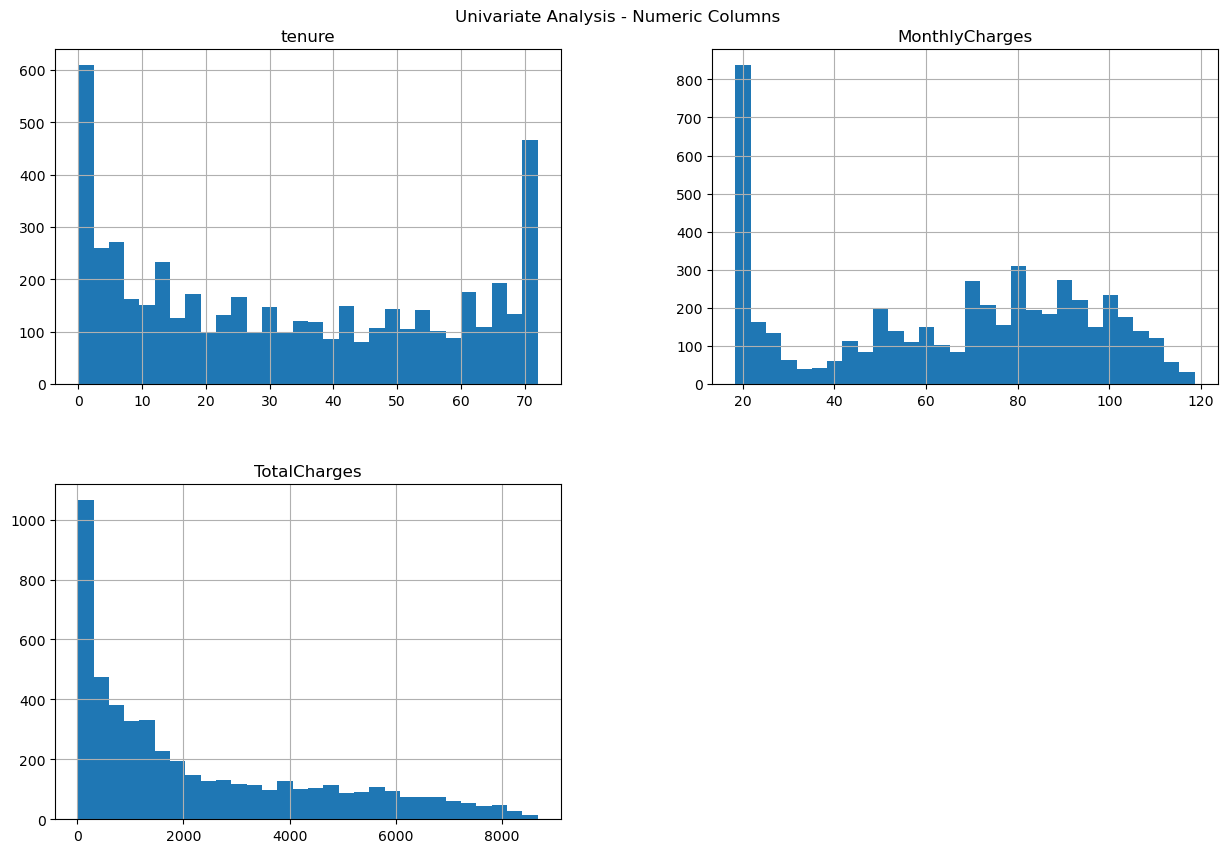

In [65]:
# Univariate Analysis
# Numeric Columns
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_train[numeric_columns].hist(bins=30, figsize=(15, 10))
plt.suptitle('Univariate Analysis - Numeric Columns', y=0.92)
plt.show()

In [66]:
# Categorical Columns(Univariate)
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                       'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

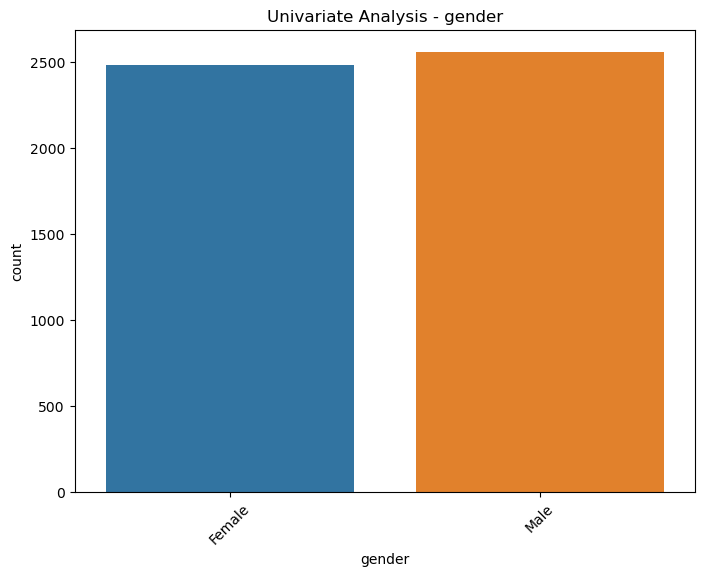

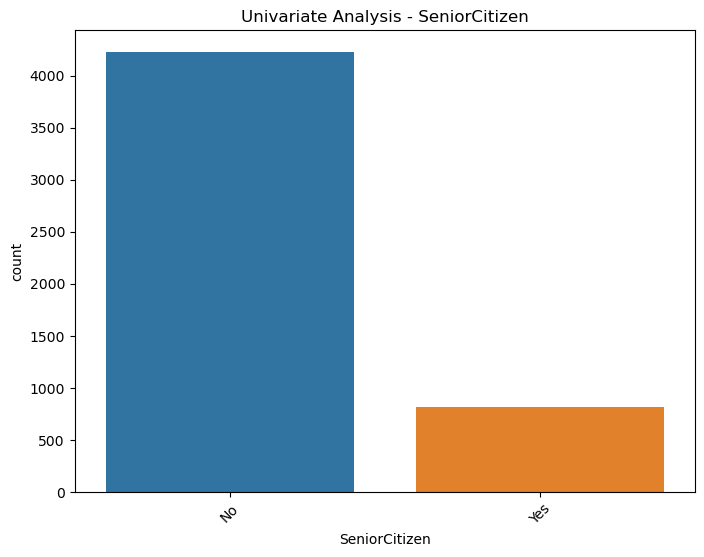

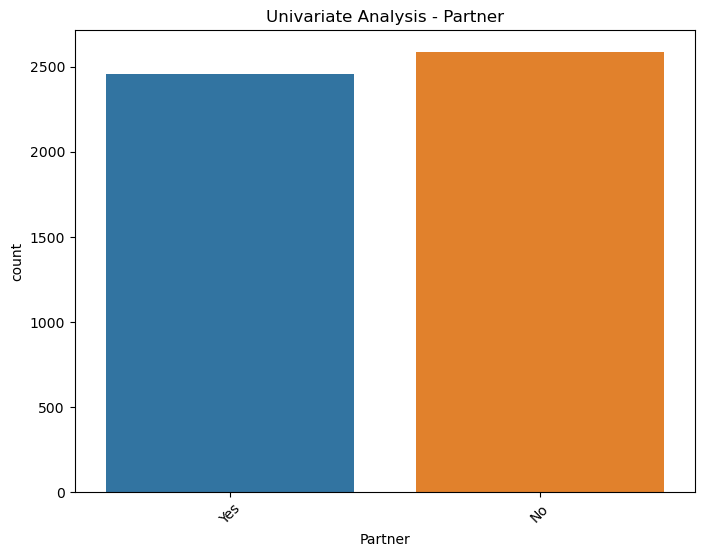

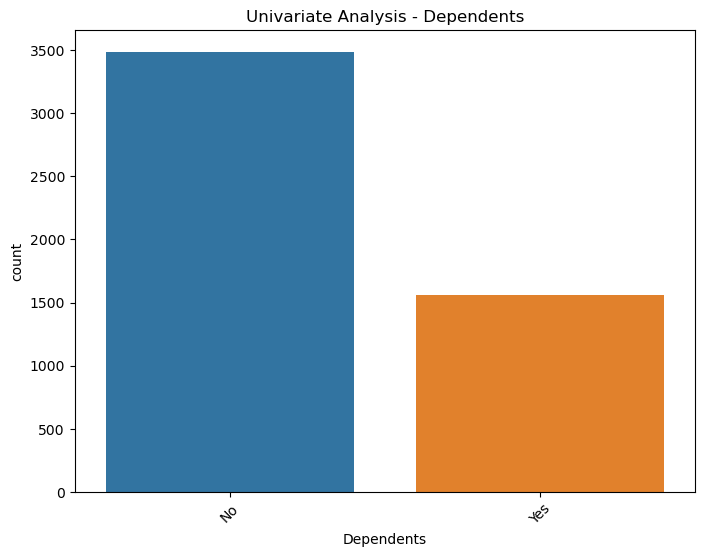

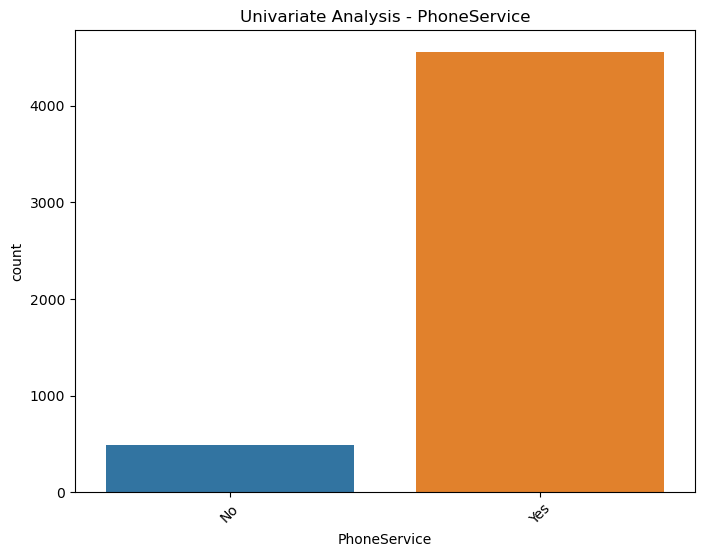

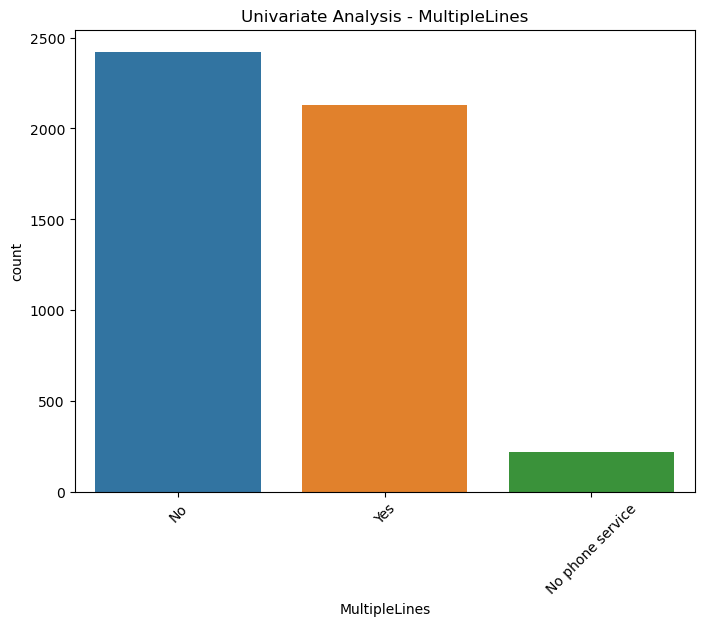

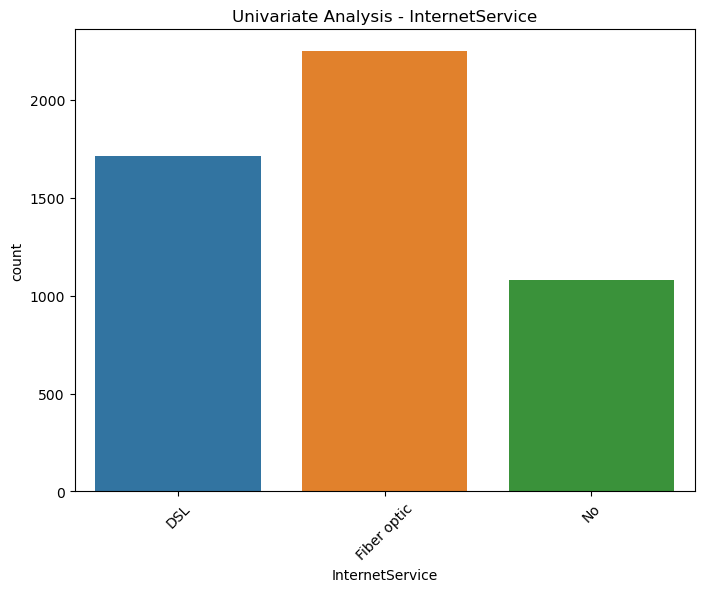

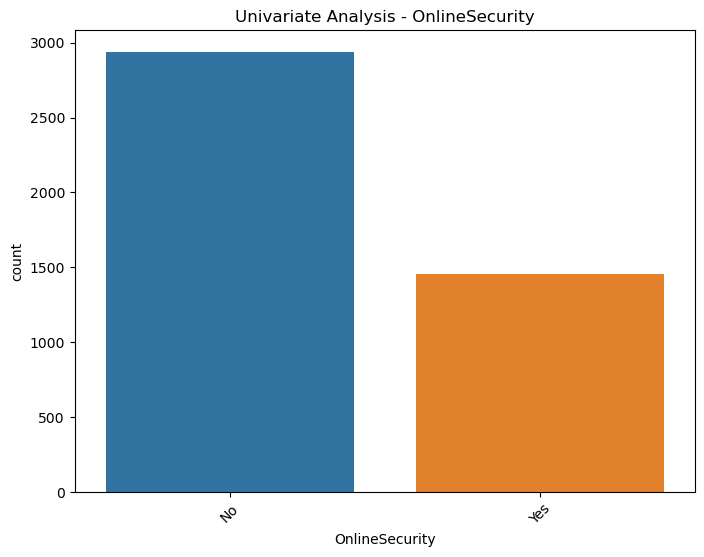

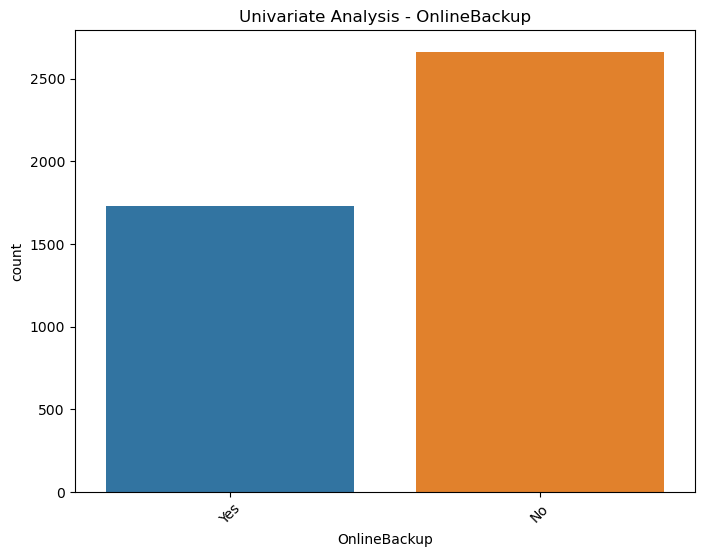

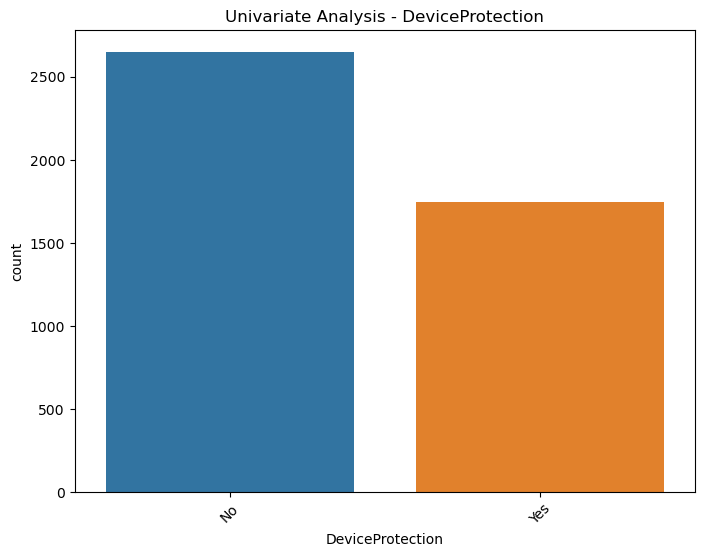

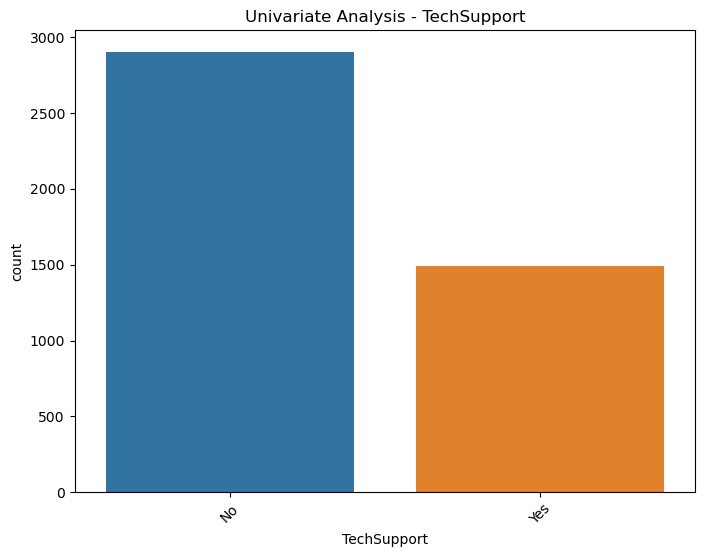

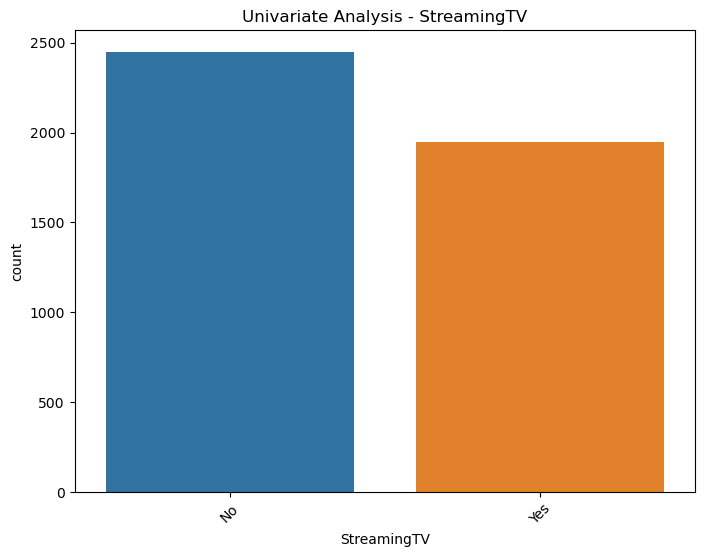

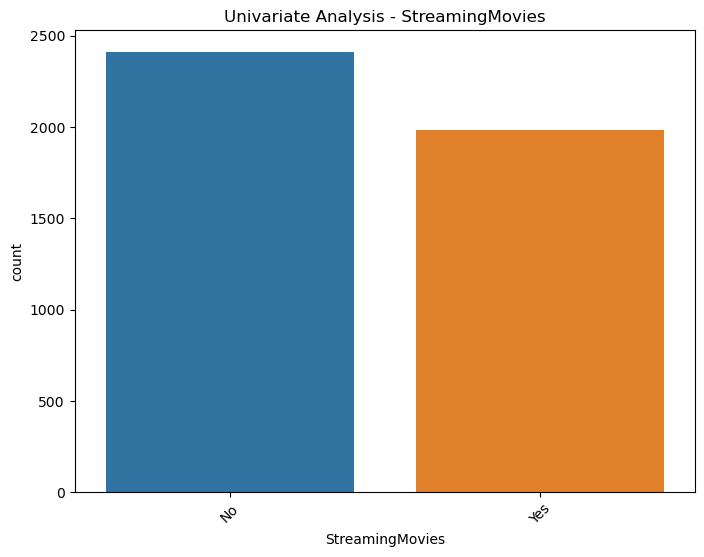

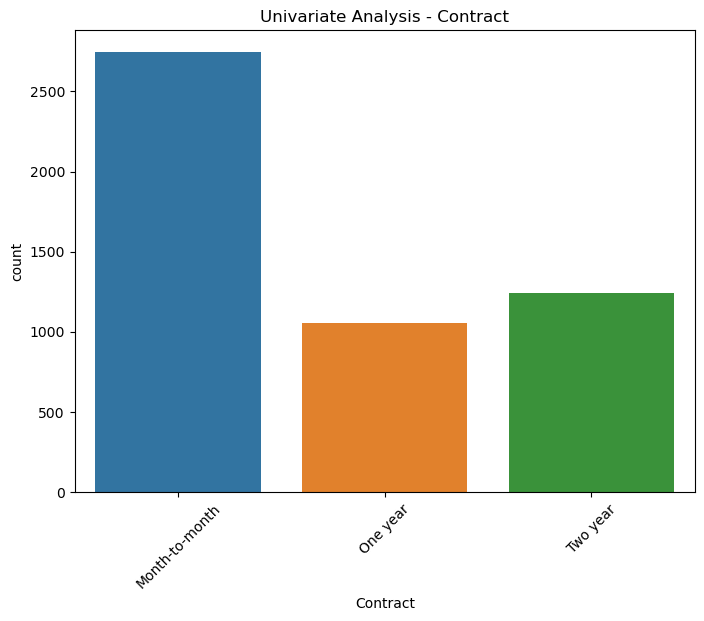

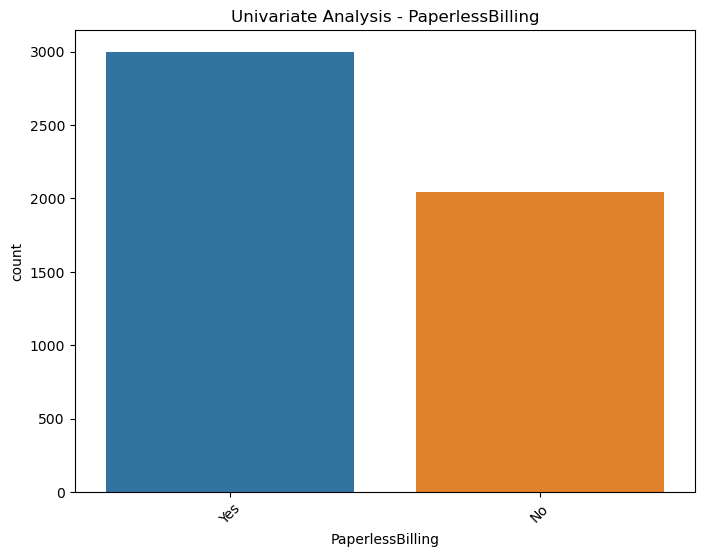

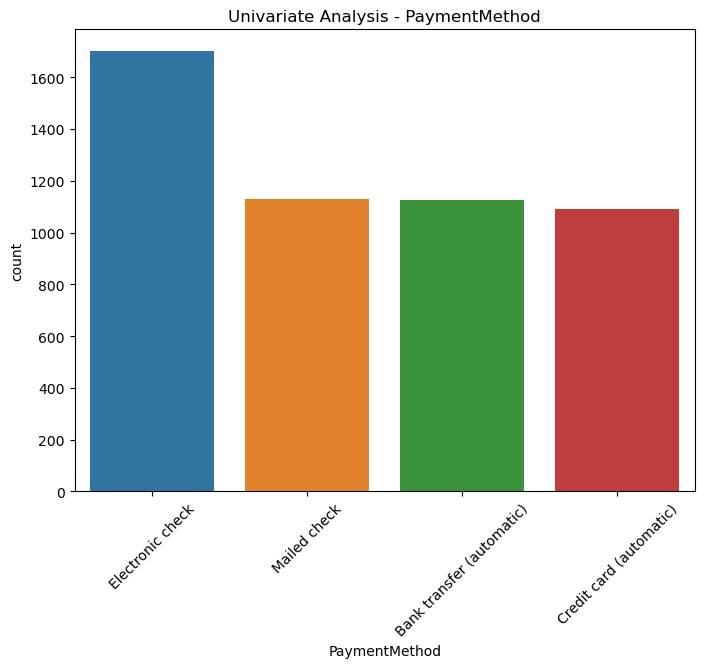

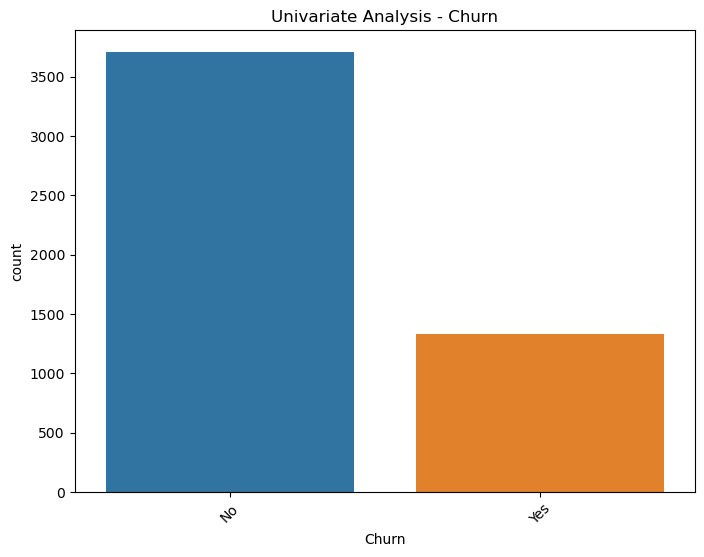

In [67]:
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=df_train)
    plt.title(f'Univariate Analysis - {column}')
    plt.xticks(rotation=45)
    plt.show()

## Bivariate Analysis 

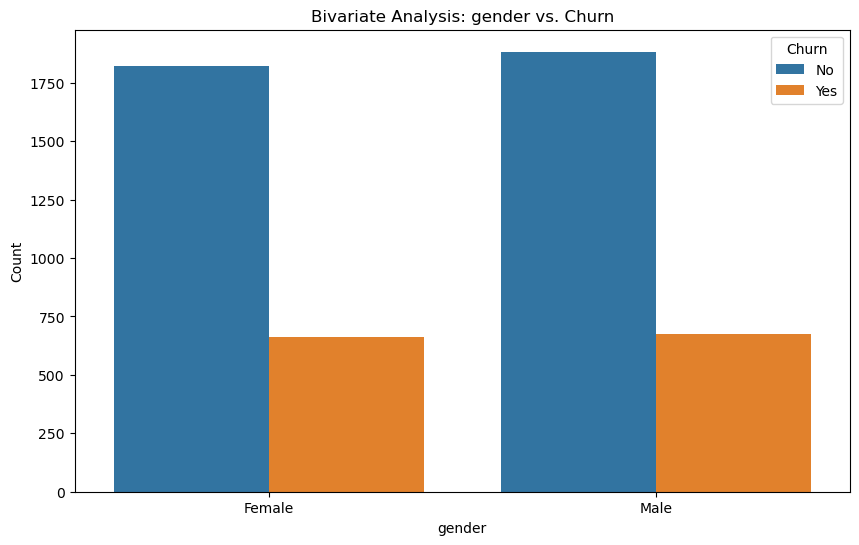

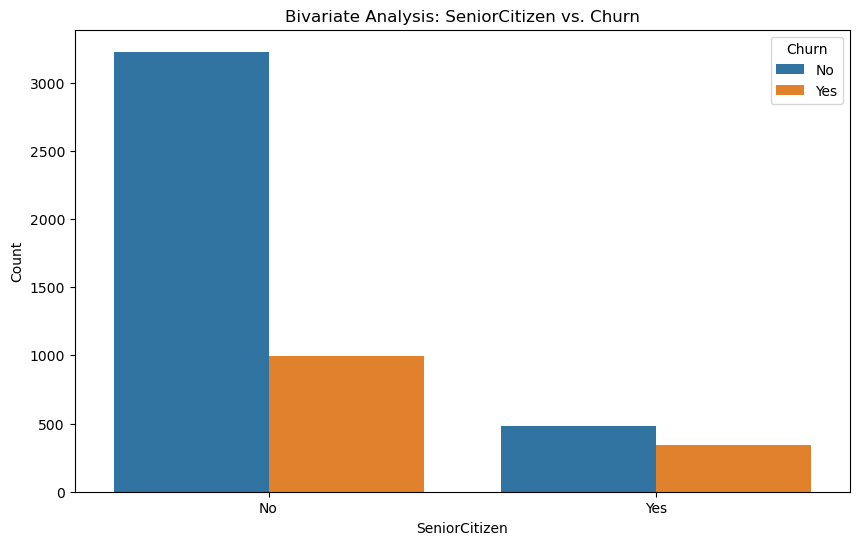

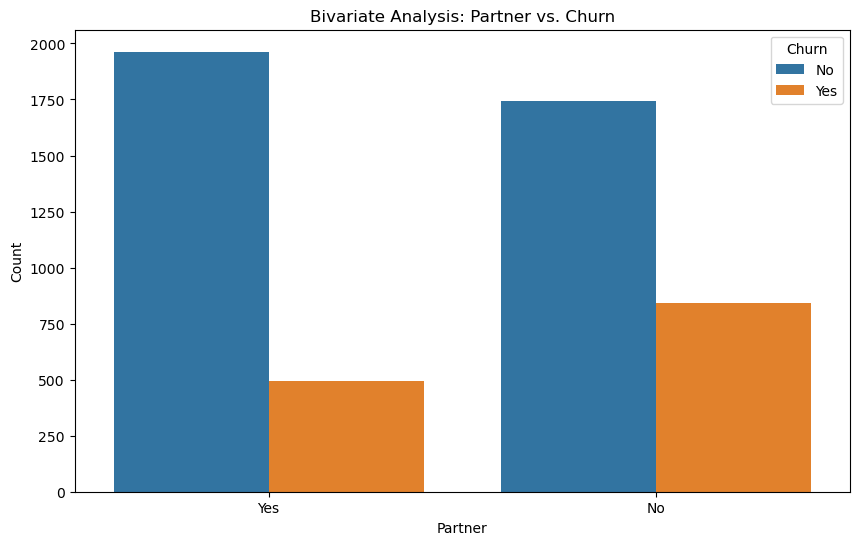

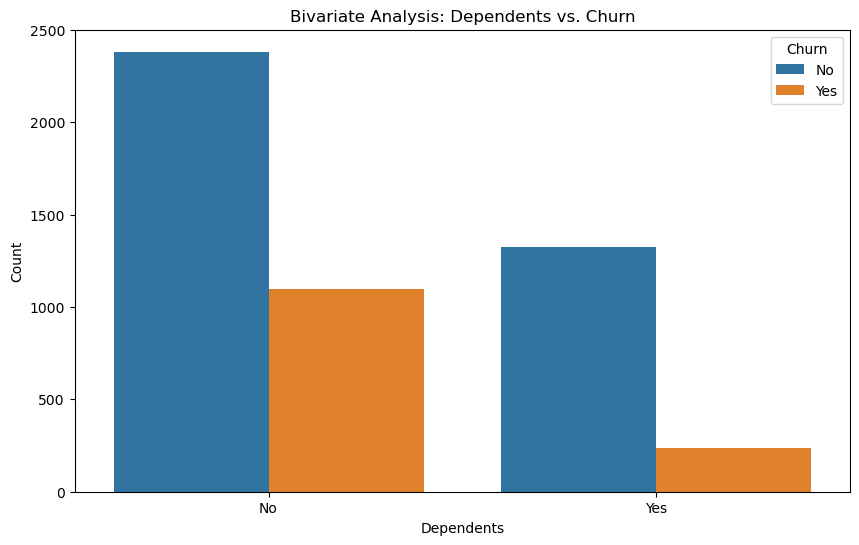

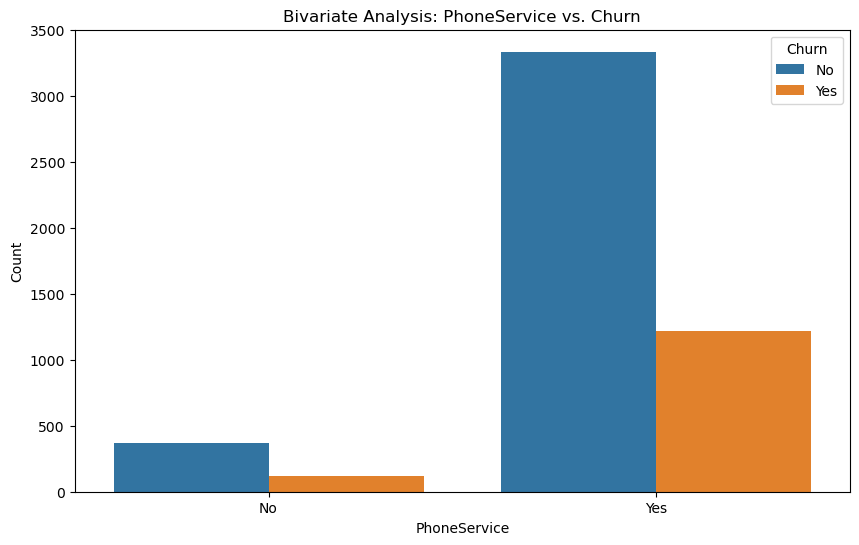

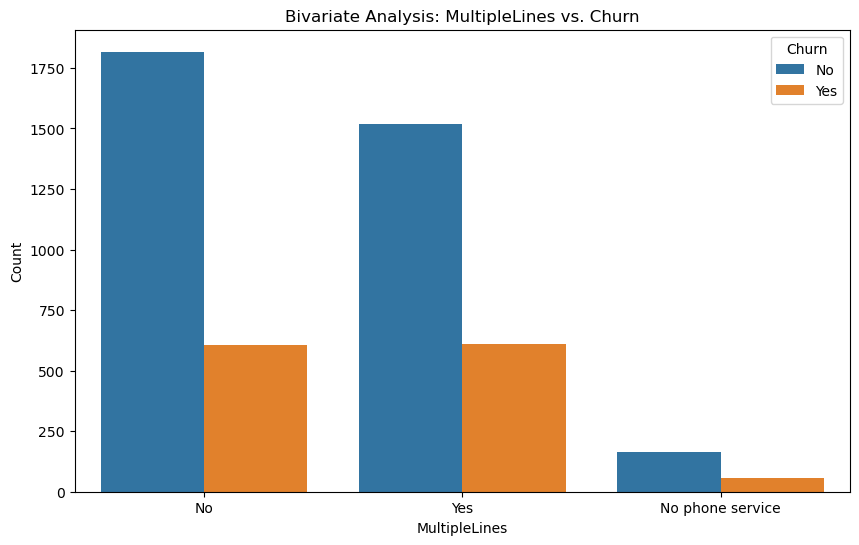

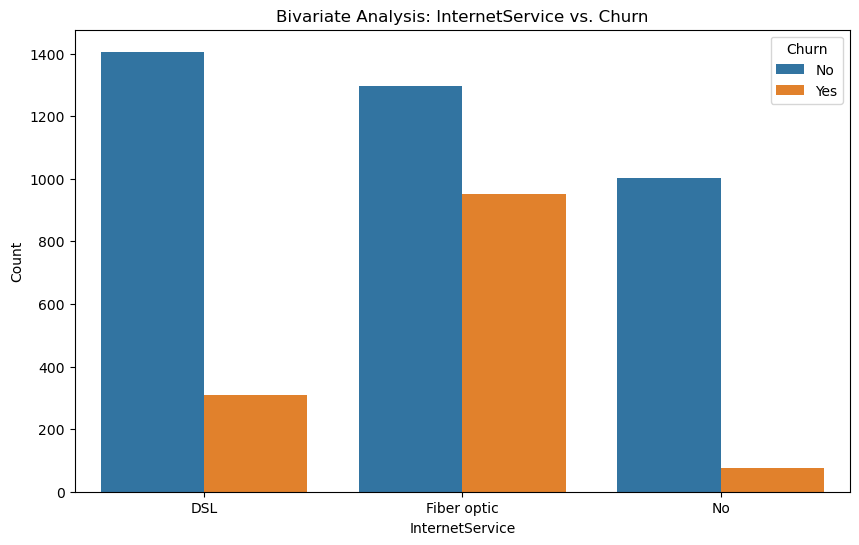

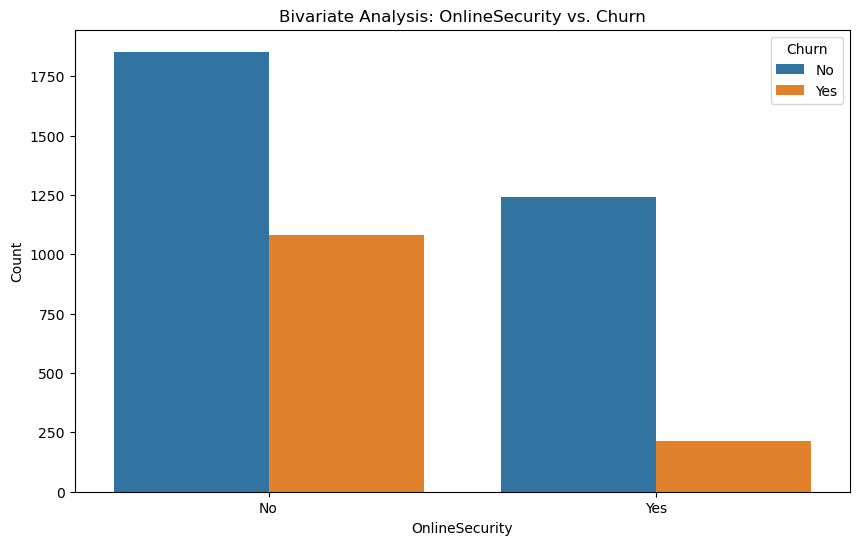

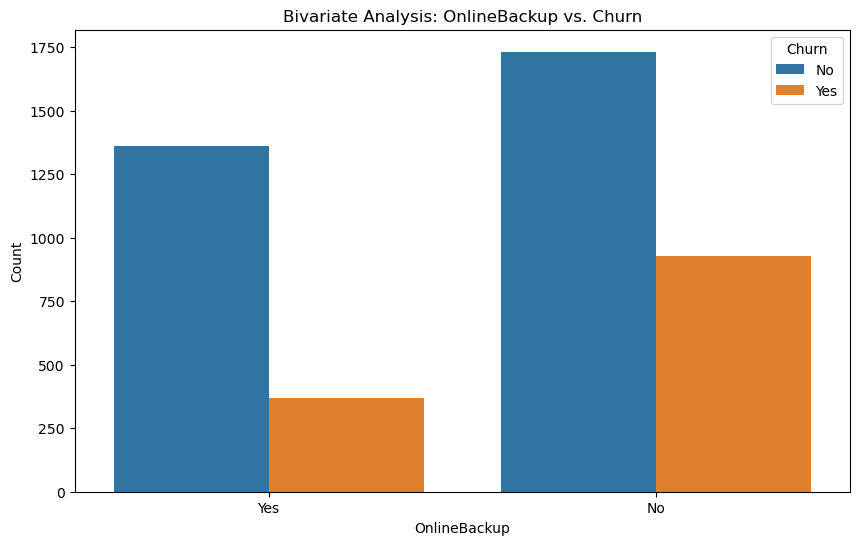

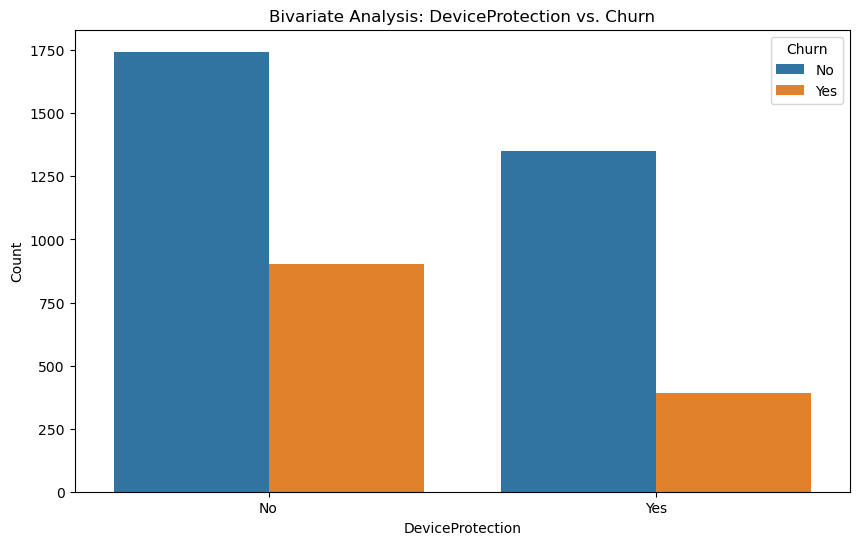

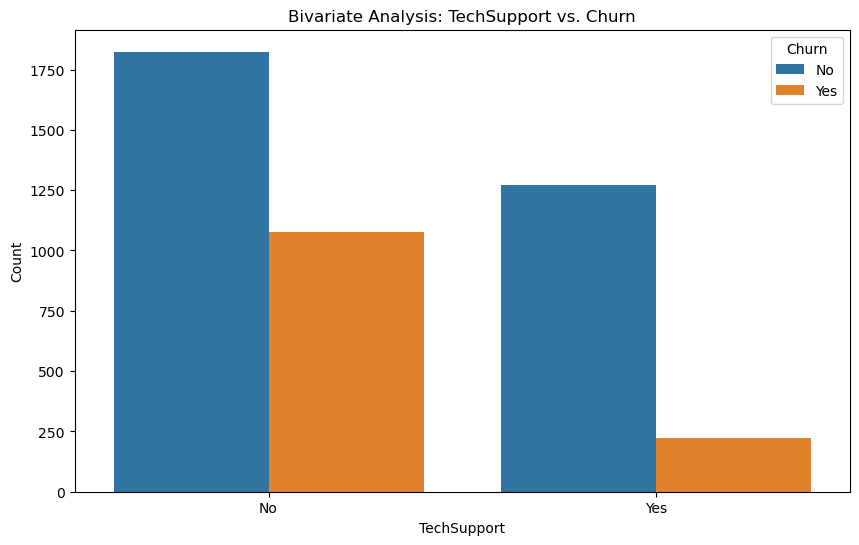

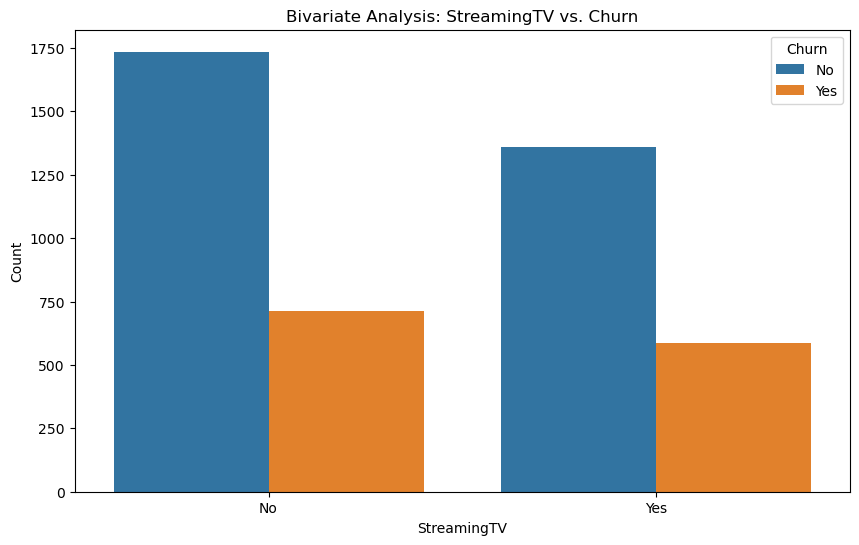

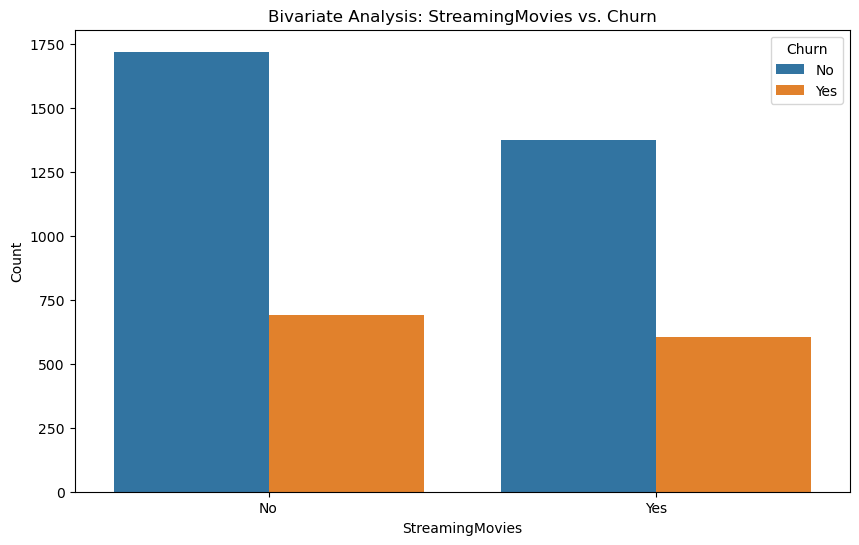

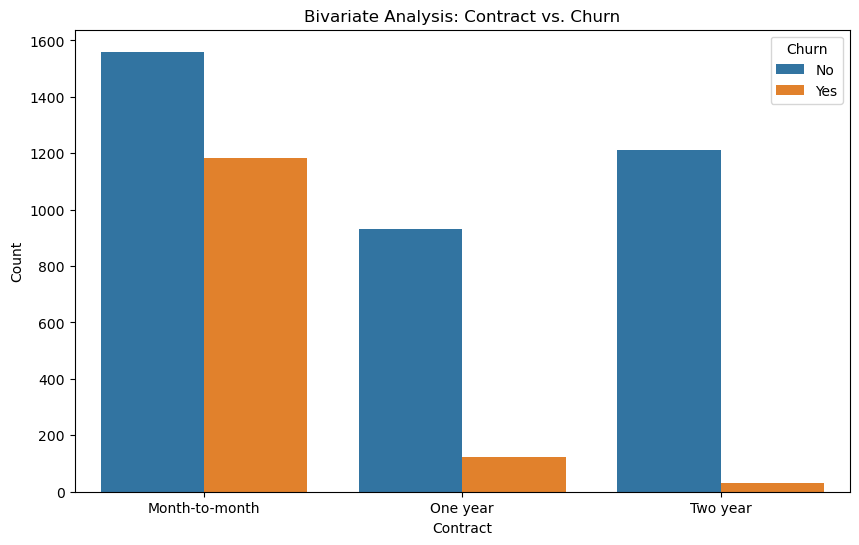

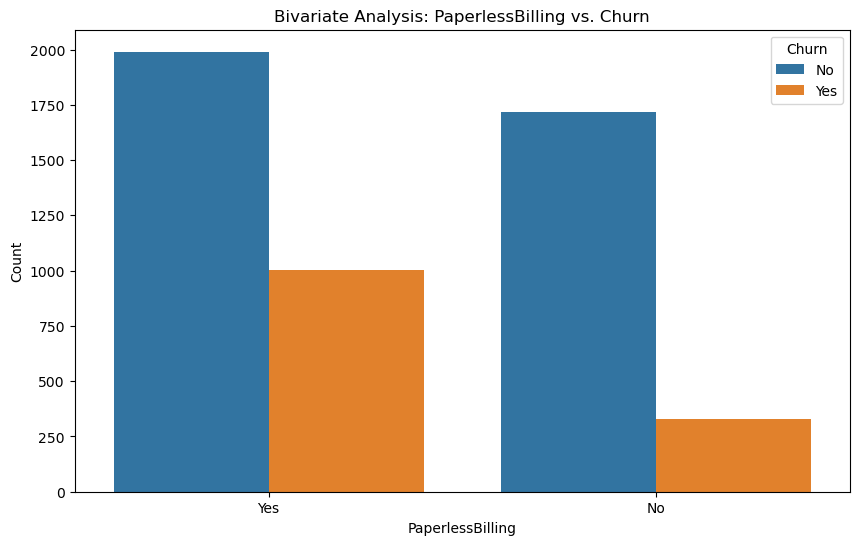

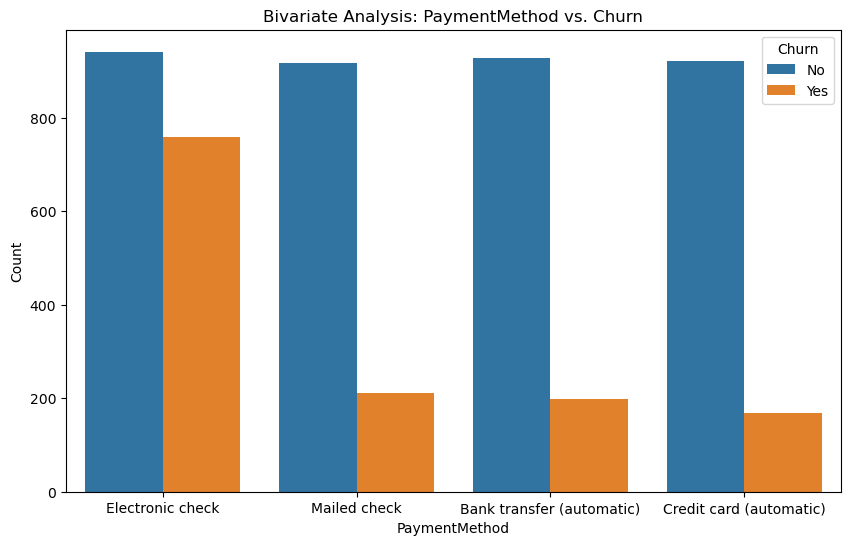

In [68]:
# Bivariate Analysis
for column in categorical_columns:
    if column != 'Churn':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=column, hue='Churn', data=df_train)
        plt.title(f'Bivariate Analysis: {column} vs. Churn')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.legend(title='Churn', labels=['No', 'Yes'])
        plt.show()

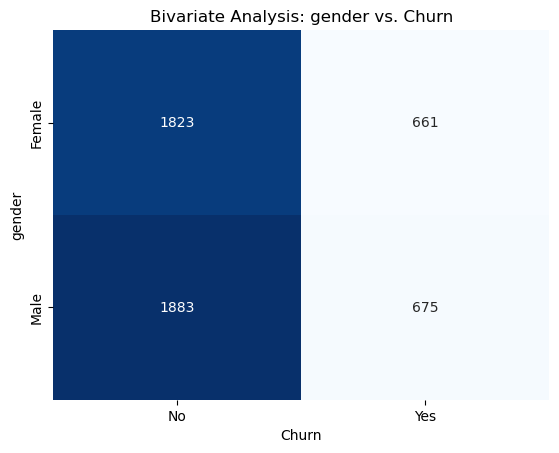

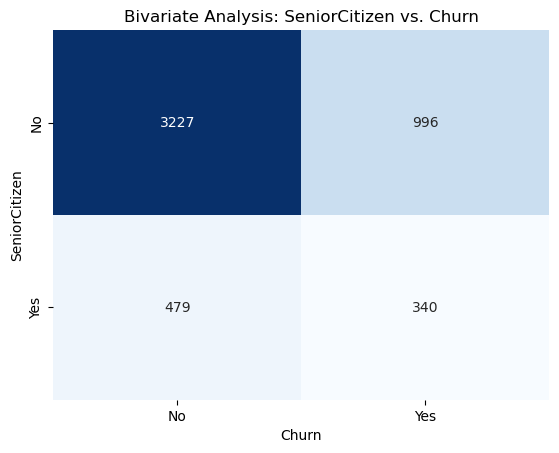

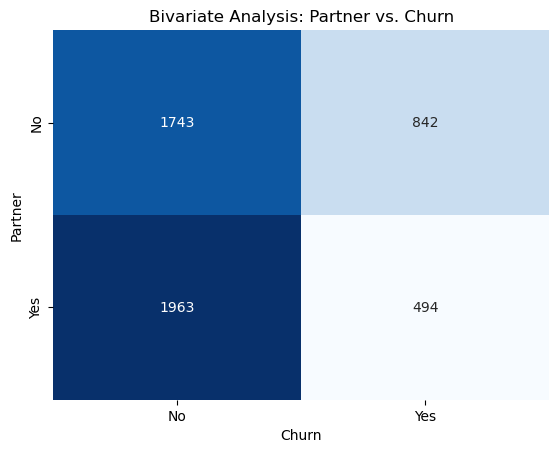

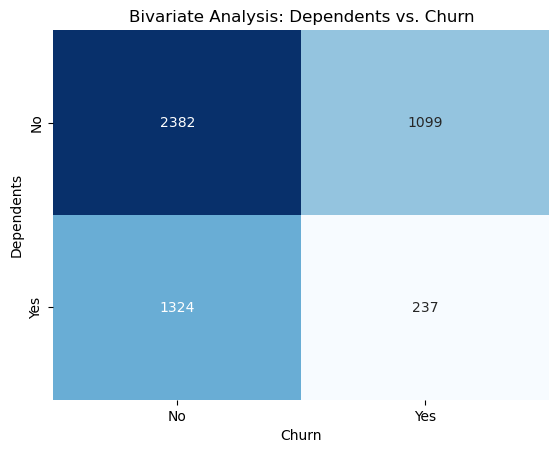

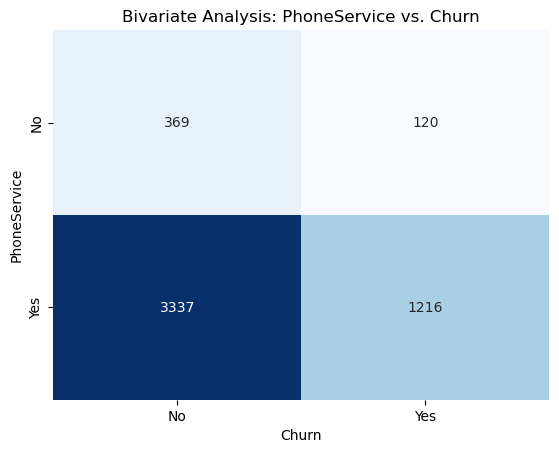

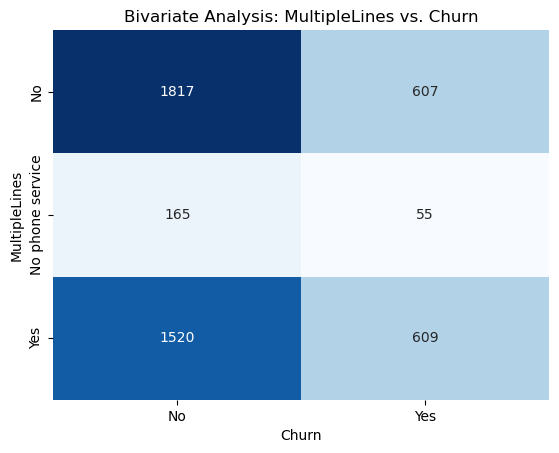

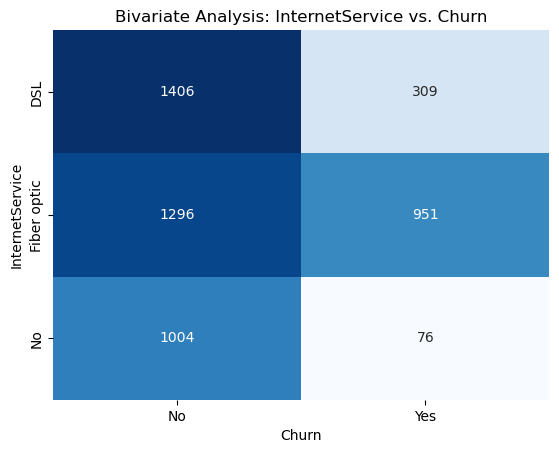

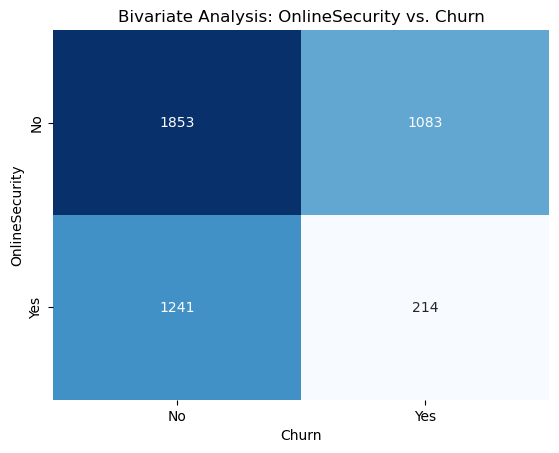

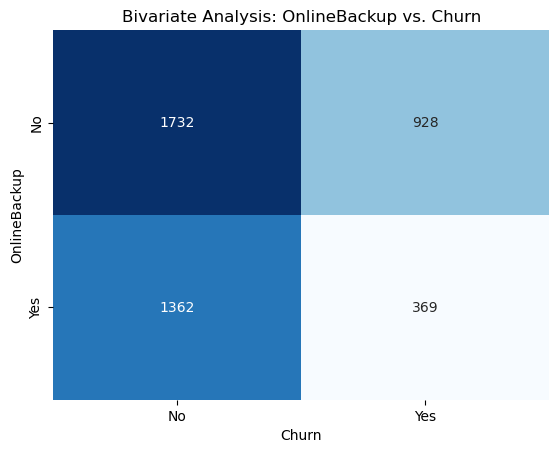

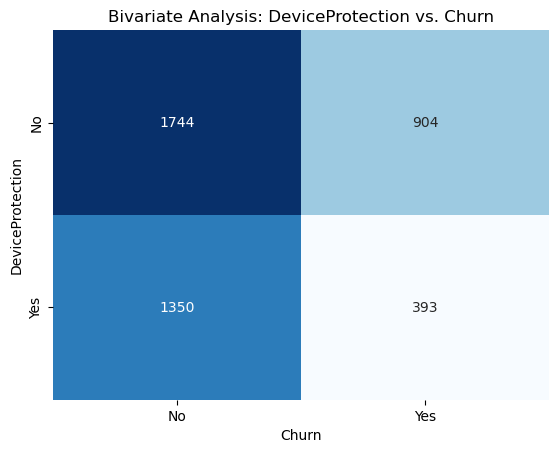

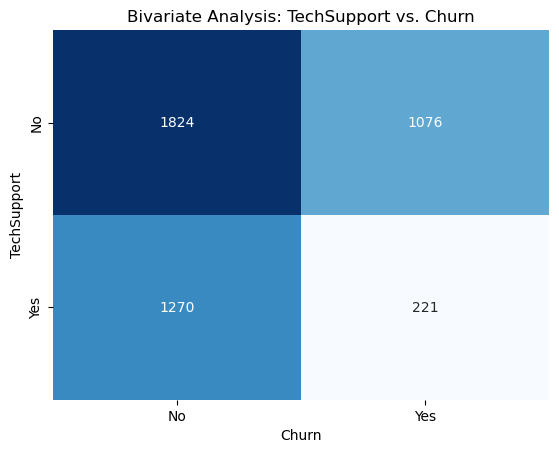

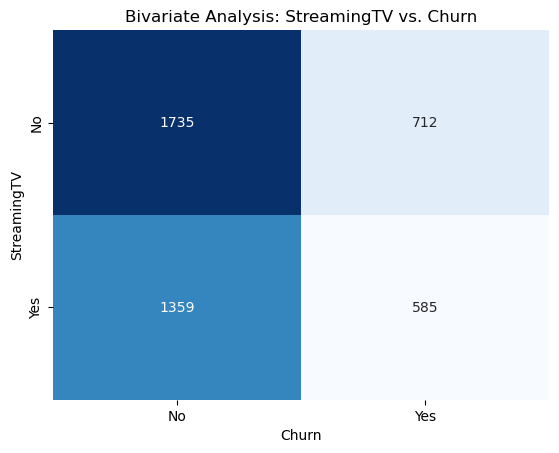

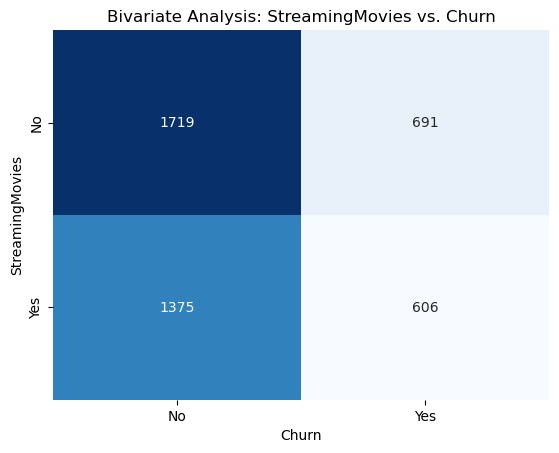

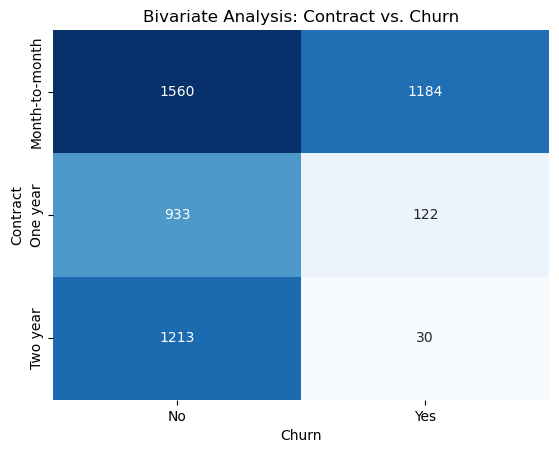

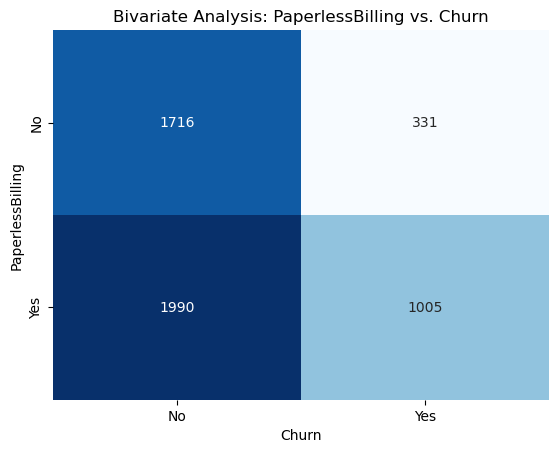

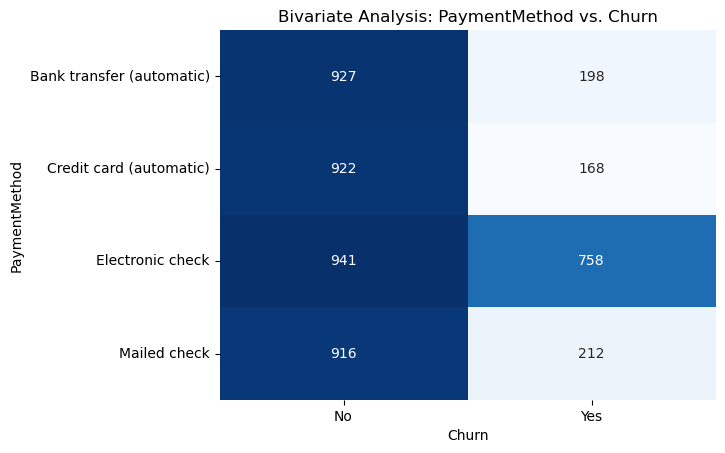

In [69]:
#Bivariate Analysis (with a heatmap)
for column in categorical_columns:
    if column != 'Churn':
        crosstab = pd.crosstab(df_train[column], df_train['Churn'])
        sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='d', cbar=False)
        plt.title(f'Bivariate Analysis: {column} vs. Churn')
        plt.xlabel('Churn')
        plt.ylabel(column)
        plt.show()

## Multivariate Analysis 

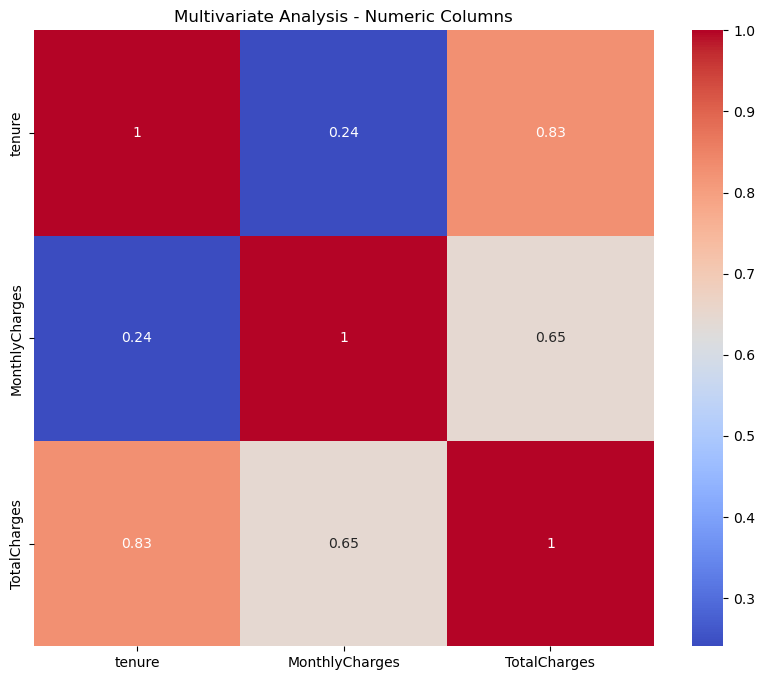

In [70]:
# Multivariate Analysis
# Numeric Columns
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(10, 8))
sns.heatmap(df_train[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Multivariate Analysis - Numeric Columns')
plt.show()


* the heatmap's diagonal pattern with correlation coefficients of 1 suggests that there is a strong positive linear relationship between 'tenure' and 'MonthlyCharges', and between 'MonthlyCharges' and 'TotalCharges'. It implies that customers with longer tenure tend to have higher monthly charges and higher total charges, while customers with shorter tenure have lower monthly charges and lower total charges.

* The Target Variable : It is the dependent variable or response variable, is the variable that you want to predict or explain in your analysis or modeling task.

In [71]:
# Target Variable distribution by percentage
100*df_train['Churn'].value_counts()/len(df_train['Churn'])

No     73.488003
Yes    26.492167
Name: Churn, dtype: float64

In [72]:
df_train['Churn'].value_counts()

No     3706
Yes    1336
Name: Churn, dtype: int64

* Data is highly imbalanced, ratio=73:27

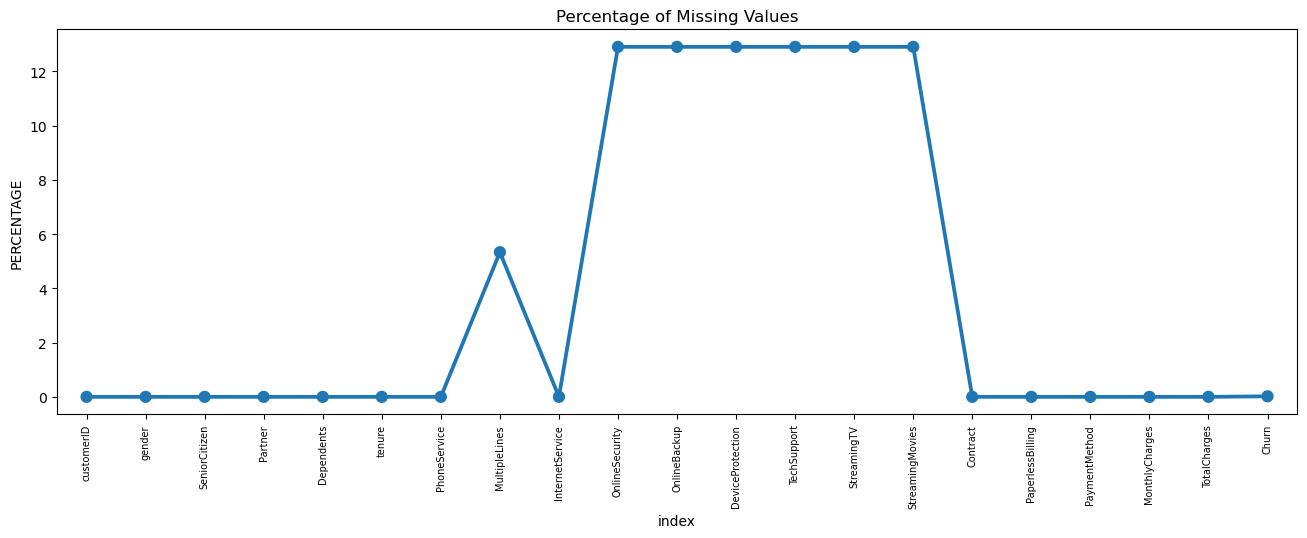

In [73]:
## Finding the percentage of missing values
missing=pd.DataFrame((df_train.isna().sum())*100/df_train.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot('index',0,data=missing)
plt.xticks(rotation=90,fontsize=7)
plt.title('Percentage of Missing Values')
plt.ylabel('PERCENTAGE')
plt.show()

## HYPOTHESIS TEST

## H0 - There is no significant difference in churn rates between male and female customers.

## H1 -Is there a significant difference in churn rates between male and female customers?

Hypothesis Test: Chi-Square Test of Independence

* The chi-square test is a statistical test used to determine if there is a significant association between two categorical variables. It is used to analyze whether the observed frequency distribution of categorical data differs significantly from the expected frequency distribution.

In [75]:
contingency_table = pd.crosstab(df_train['gender'], df_train['Churn'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Set the significance level
alpha = 0.05

# Print the results
print("Chi-Square Test of Independence - Gender vs. Churn")
print(f"Chi2 statistic: {chi2}")
print(f"P-value: {p_value}")

# Check the result based on the significance level
if p_value < alpha:
    print("There is a significant association between gender and churn.")
else:
    print("There is no significant association between gender and churn.")


Chi-Square Test of Independence - Gender vs. Churn
Chi2 statistic: 0.021628520637713346
P-value: 0.8830796247912641
There is no significant association between gender and churn.


The Chi2 statistic is a measure of the discrepancy between the observed frequencies and the frequencies that would be expected if the two variables (gender and churn) were independent. A smaller Chi2 statistic indicates a smaller discrepancy.

Our p-value (0.8) is greater than the commonly used significance level of 0.05, we fail to reject the null hypothesis. This means that there is not enough evidence to suggest a significant association between gender and churn. Therefore, we can conclude that gender does not have a significant influence on customer churn based on the available data.

## H0 : The type of internet service does not influence customer churn.

## H1 : Does the type of internet service influence customer churn?

Hypothesis Test: Chi-Square Test of Independence

In [76]:
contingency_table = pd.crosstab(df_train['InternetService'], df_train['Churn'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Set the significance level
alpha = 0.05

# Print the results
print("Chi-Square Test of Independence - Internet Service vs. Churn")
print(f"Chi2 statistic: {chi2:.2f}")
print(f"P-value: {p_value:.2f}")

# Check the result based on the significance level
if p_value < alpha:
    print("There is a significant association between Internet Service and Churn.")
else:
    print("There is no significant association between Internet Service and Churn.")


Chi-Square Test of Independence - Internet Service vs. Churn
Chi2 statistic: 562.27
P-value: 0.00
There is a significant association between Internet Service and Churn.


The chi2 statistic measures the degree of association between the variables (Internet Service and Churn)

the p-value is extremely small (0.00), significantly lower than the common significance level of 0.05, we reject the null hypothesis. This means that there is strong evidence to suggest a significant association between Internet Service and Churn. The result indicates that the type of Internet Service a customer has is likely to have an impact on their likelihood to churn.

## H0 :Customers with a longer tenure more likely to churn.

## H1 : Are customers with a longer tenure less likely to churn?

Hypothesis Test: T-test 

* Ttest is a statistical test used to determine if there is a significant difference between the means of two groups or populations.

In [77]:
group1 = df_train[df_train['Churn'] == 'No']['tenure'].values
group2 = df_train[df_train['Churn'] == 'Yes']['tenure'].values

t_statistic, p_value = ttest_ind(group1, group2)

# Set the significance level
alpha = 0.05

# Print the results
print("Independent t-test - Tenure vs. Churn")
print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.2f}")

# Check the result based on the significance level
if p_value < alpha:
    print("There is a significant difference in tenure between churned and non-churned customers.")
else:
    print("There is no significant difference in tenure between churned and non-churned customers.")


Independent t-test - Tenure vs. Churn
T-statistic: 26.59
P-value: 0.00
There is a significant difference in tenure between churned and non-churned customers.


The t-statistic value is 26.60. This value represents the magnitude of the difference in the average tenure between churned and non-churned customers. 

The p-value is 0.00. This value represents the probability of obtaining the observed difference in tenure between churned and non-churned customers by chance alone. In this case, the p-value is extremely small, indicating strong evidence against the null hypothesis (no difference).

## H0 - The payment method does not influence customer churn.

## H1- Does the payment method influence customer churn?

Hypothesis Test: Chi-Square Test of Independence

In [78]:
contingency_table = pd.crosstab(df_train['PaymentMethod'], df_train['Churn'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Set the significance level
alpha = 0.05

# Print the results
print("Chi-Square Test of Independence - Payment Method vs. Churn")
print(f"Chi2 statistic: {chi2:.2f}")
print(f"P-value: {p_value:.2f}")

# Check the result based on the significance level
if p_value < alpha:
    print("There is a significant association between Payment Method and Churn.")
else:
    print("There is no significant association between Payment Method and Churn.")


Chi-Square Test of Independence - Payment Method vs. Churn
Chi2 statistic: 435.18
P-value: 0.00
There is a significant association between Payment Method and Churn.


A Chi2 statistic of 434.58 indicates a stronger association

The p-value of (0.00) represents the probability of observing the association between Payment Method and Churn by chance alone.

we can conclude that there is a significant association between Payment Method and Churn. The choice of Payment Method appears to have an influence on the likelihood of a customer churning.

## Answering Questions with Visualizations

## Question 1:  Is there a significant difference in churn rates between male and female customers?

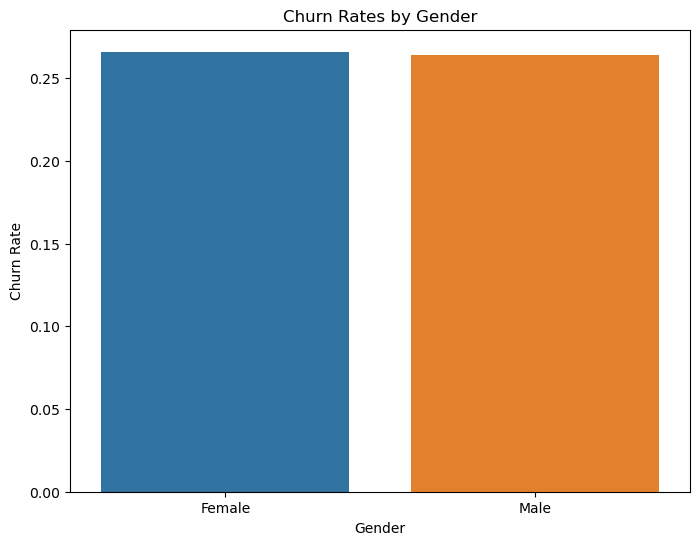

In [79]:
# Create a contingency table of gender and churn
contingency_table = pd.crosstab(df_train['gender'], df_train['Churn'])

# Calculate the churn rates by gender
churn_rates = contingency_table['Yes'] / contingency_table.sum(axis=1)

# Plot the churn rates
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.title('Churn Rates by Gender')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')
plt.show()


The female churn rate is approximately 0.25 and the male churn rate is approximately 0.23, it suggests that there is a slight difference in churn rates between the two genders. However, the difference is relatively small.

This means that, on average, the churn rate for female customers is slightly higher than the churn rate for male customers, but the difference is not substantial. It indicates that gender alone may not be a strong predictor of customer churn in this dataset. 

## Question 2 : Does the type of internet service influence customer churn

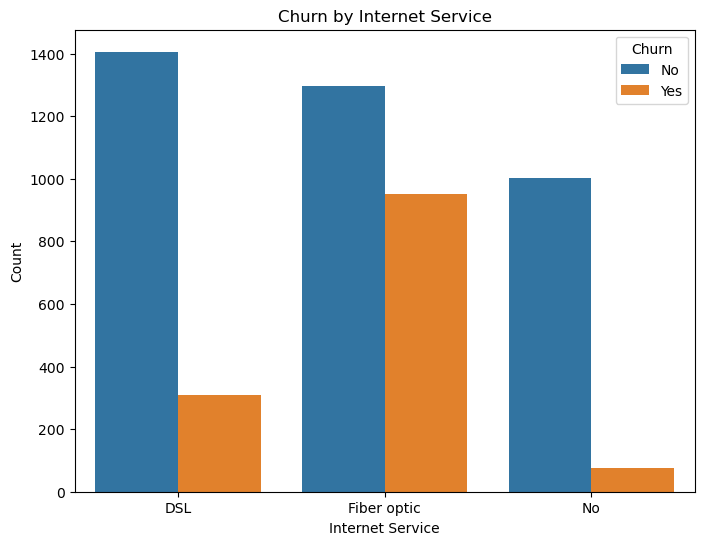

In [80]:
plt.figure(figsize=(8, 6))
sns.countplot(x='InternetService', hue='Churn', data=df_train)
plt.title('Churn by Internet Service')
plt.xlabel('Internet Service')
plt.ylabel('Count')
plt.show()

The results of the visualization indicate that customers with DSL internet service have the highest number of non-churned customers, with a count of 1400. On the other hand, the count of churned customers for DSL internet service is 300. 

This suggests that customers with DSL internet service are less likely to churn compared to other internet service types. Optics, on the other hand, has a lower count of non-churned customers and a higher count of churned customers. 

In summary, the type of internet service does seem to influence customer churn, with DSL internet service showing a lower churn rate compared to other types.

##  Question 3 - Are customers with a longer tenure less likely to churn 

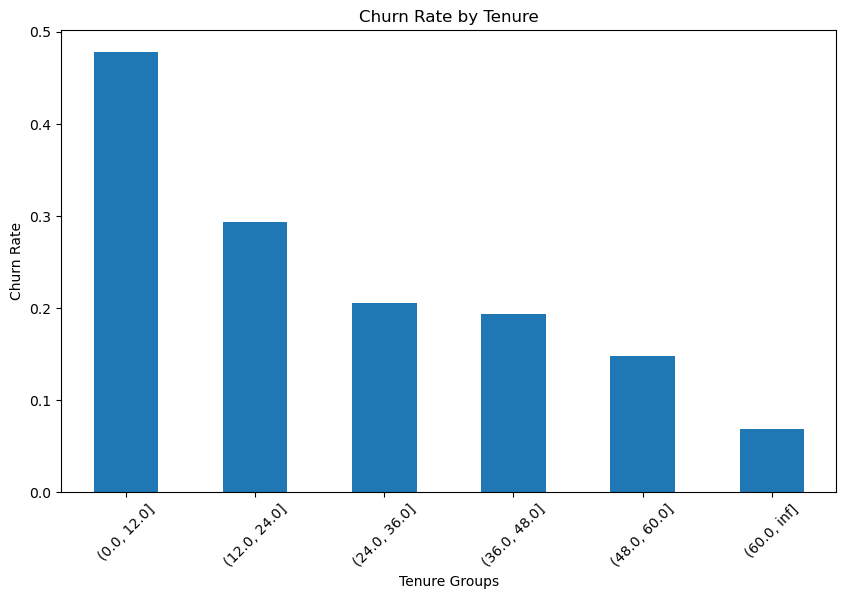

In [81]:
# Calculate churn rate for different tenure groups
tenure_groups = df_train.groupby(pd.cut(df_train['tenure'], bins=[0, 12, 24, 36, 48, 60, float('inf')]))
churn_rate = tenure_groups['Churn'].value_counts(normalize=True).unstack()['Yes']

# Plot the churn rate
plt.figure(figsize=(10, 6))
churn_rate.plot(kind='bar')
plt.title('Churn Rate by Tenure')
plt.xlabel('Tenure Groups')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()


Customers with a tenure of 0-12 months have the highest churn rate of 0.4. This indicates that customers who are relatively new to the service are more likely to churn. It could be because they are still in the early stages of evaluating the service or may have encountered issues that led to dissatisfaction.

Customers with a tenure of 24-36 months have a lower churn rate of 0.2. This suggests that customers who have been with the service for a moderate amount of time are less likely to churn compared to those with shorter tenures. 

Customers with a tenure of 60 months and above have the lowest churn rate of 0.05. This indicates that customers who have been with the service for a longer duration are significantly less likely to churn. These customers have likely developed a strong relationship with the service provider, are satisfied with the service, and may have a higher level of loyalty. 

In summary, the results suggest that there is a correlation between tenure and churn rate. Customers with longer tenures are indeed less likely to churn compared to those with shorter tenures. 

## Question 4 : Does the payment method influence customer churn?

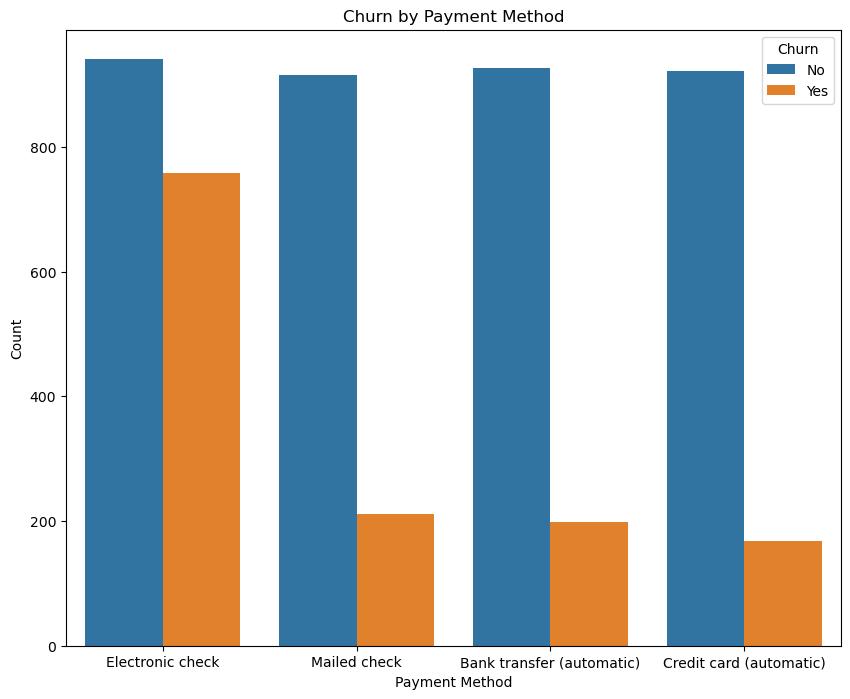

In [82]:
plt.figure(figsize=(10, 8))
sns.countplot(x='PaymentMethod', hue='Churn', data=df_train)
plt.title('Churn by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.show()

The results of the visualization indicate that the payment method of "Electronic check" has the highest count of both non-churned and churned customers, with approximately 900 non-churned and 750 churned customers. On the other hand, the payment methods "Mail check," "Bank transfer (automatic)," and "Credit card (automatic)" have a relatively similar number of customers at around 900, but their churn count is significantly lower at approximately 200.

This suggests that the payment method of "Electronic check" has a higher churn rate compared to other payment methods. Customers who use electronic checks as their payment method are more likely to churn compared to customers who use other payment methods such as mail check, bank transfer (automatic), or credit card (automatic).

In summary, the payment method does seem to influence customer churn, with electronic check users having a higher churn rate compared to other payment methods.

In [83]:
df_train.to_csv('Attrition Train.csv')

## Feature Processing & Engineering

* This includes Dropping missing values and replacing some

In [84]:
# Assuming your DataFrame is named 'df'
missing_values = df_train[df_train.isnull().any(axis=1)]

missing_values.head(50)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,None,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
3,7795-CFOCW,Male,No,No,No,45,No,None,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
7,6713-OKOMC,Female,No,No,No,10,No,None,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.750000,301.899994,No
11,7469-LKBCI,Male,No,No,No,16,Yes,No,No,None,...,None,None,None,None,Two year,No,Credit card (automatic),18.950001,326.799988,No
16,8191-XWSZG,Female,No,No,No,52,Yes,No,No,None,...,None,None,None,None,One year,No,Mailed check,20.650000,1022.950012,No
20,8779-QRDMV,Male,Yes,No,No,1,No,None,DSL,No,...,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.650002,39.650002,Yes
21,1680-VDCWW,Male,No,Yes,No,12,Yes,No,No,None,...,None,None,None,None,One year,No,Bank transfer (automatic),19.799999,202.250000,No
22,1066-JKSGK,Male,No,No,No,1,Yes,No,No,None,...,None,None,None,None,Month-to-month,No,Mailed check,20.150000,20.150000,Yes
27,8665-UTDHZ,Male,No,Yes,Yes,1,No,None,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,30.200001,30.200001,Yes
33,7310-EGVHZ,Male,No,No,No,1,Yes,No,No,None,...,None,None,None,None,Month-to-month,No,Bank transfer (automatic),20.200001,20.200001,No


In [85]:
df_train.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 1
dtype: int64

In [86]:
df_train.dropna(subset=['Churn'], inplace=True)

* Drop missing value in the Churn column. In this case it is only one so it safe to drop.

In [87]:
# Create a NumPy array to represent the target variable
target = np.where(df_train['Churn'] == 'Yes', 1, 0)

# Assign the new NumPy array to the 'Churn' column
df_train['Churn'] = target

# Verify the conversion
df_train['Churn'].unique 

<bound method Series.unique of 0       0
1       0
2       1
3       0
4       1
       ..
2038    0
2039    0
2040    0
2041    1
2042    0
Name: Churn, Length: 5042, dtype: int32>

* Converting the Target variable to a binary numeric value Yes:1, No:0

In [88]:
df_train.drop("customerID", axis=1, inplace=True)

* Drop the CustomerID column because it relevance is limited

In [89]:
# Replace missing values in specific columns
columns_to_replace = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
for column in columns_to_replace:
    df_train[column] = np.where((df_train["InternetService"] == "No") & (df_train[column].isnull()), "No internet service", df_train[column])

* The rationale behind the code is to replace missing values in certain columns with "No" based on the condition that the corresponding customer does not have an internet service. This is because, without internet service, the specific services (e.g., online security, device protection) are not applicable or available

In [90]:
# Check for the mode of the column

mode_value = df_train['MultipleLines'].mode()[0]
print("Mode value in 'MultipleLines' column:", mode_value)

Mode value in 'MultipleLines' column: No


In [91]:
# Check fot the count distribution of the column

value_counts = df_train['MultipleLines'].value_counts()
print("Counts of 'No' and 'Yes' in 'MultipleLines' column:")
print(value_counts)

Counts of 'No' and 'Yes' in 'MultipleLines' column:
No                  2424
Yes                 2129
No phone service     220
Name: MultipleLines, dtype: int64


In [92]:
df_train['MultipleLines'].fillna(mode_value, inplace=True)

In [93]:
categorical = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines', 
               'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
               'StreamingTV','StreamingMovies', 'Contract','PaperlessBilling','PaymentMethod']

In [94]:
numerical = ['tenure', 'MonthlyCharges', 'TotalCharges']

## Dataset Splitting

In [95]:
X = df_train.drop(columns = "Churn")
y = df_train["Churn"].values

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4, stratify =y)

In [97]:
print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Training set size: (4033, 19) (4033,)
Testing set size: (1009, 19) (1009,)


## Impute Missing Values

In [98]:
# Impute missing values with the mode for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = categorical_imputer.fit_transform(X_train[categorical])
X_test_imputed = categorical_imputer.transform(X_test[categorical])

In [99]:
# Impute missing values with the mean for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
X_train_imputed = numerical_imputer.fit_transform(X_train[numerical])
X_test_imputed = numerical_imputer.transform(X_test[numerical])

* This step is to ensure that the imputation is performed independently on the training and test sets to avoid any data leakage. 

## New Features Creation

In [100]:
df_train = df_train.dropna()

In [101]:
# Calculate the ratio of monthly charges to total charges for train data
X_train['MonthlyCharges_TotalCharges_Ratio'] = X_train['MonthlyCharges'] / X_train['TotalCharges']

# Calculate the ratio of monthly charges to total charges for test data
X_test['MonthlyCharges_TotalCharges_Ratio'] = X_test['MonthlyCharges'] / X_test['TotalCharges']

In [102]:
# Append the new feature to the numerical list
numerical.append('MonthlyCharges_TotalCharges_Ratio')

* It indicate whether the customer consistently pays their monthly charges or has any outstanding balance. This feature could capture patterns or correlations between the payment behavior and the likelihood of churn

In [103]:
print(numerical)

['tenure', 'MonthlyCharges', 'TotalCharges', 'MonthlyCharges_TotalCharges_Ratio']


## Feature Encoding

In [104]:
# Apply one-hot encoding on the training set
encoder = OneHotEncoder(drop='if_binary')
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical]).toarray(),
                               columns=encoder.get_feature_names_out(categorical),
                               index=X_train.index)

# Apply the same encoding on the testing set
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical]).toarray(),
                              columns=encoder.get_feature_names_out(categorical),
                              index=X_test.index)

## Feature Scaling

In [105]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric variables in the training set
X_train_encoded[numerical] = scaler.fit_transform(X_train[numerical])

# Transform the numeric variables in the testing set using the fitted scaler
X_test_encoded[numerical] = scaler.transform(X_test[numerical])

In [106]:
# Concatenate the encoded & scaled training and testing sets
X_encoded = pd.concat([X_train_encoded, X_test_encoded], axis=0)

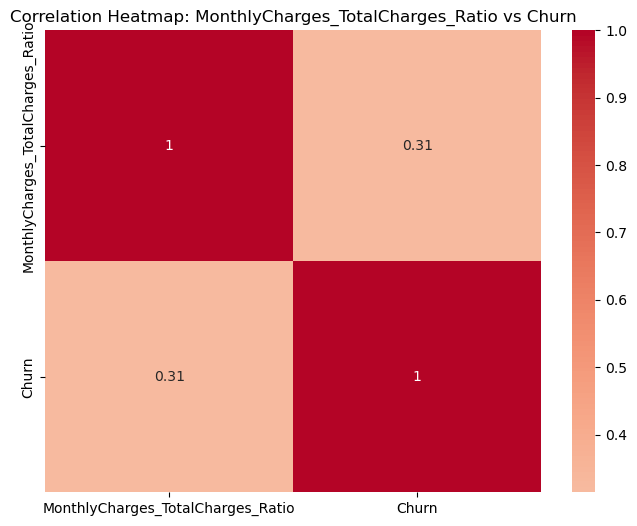

In [107]:
# Reset the index of X_train
X_train.reset_index(drop=True, inplace=True)

# Create a new DataFrame with the target variable and the "MonthlyCharges_TotalCharges_Ratio" column
correlation_df = pd.concat([X_train['MonthlyCharges_TotalCharges_Ratio'], pd.Series(y_train, name='Churn')], axis=1)

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap: MonthlyCharges_TotalCharges_Ratio vs Churn')
plt.show()

## Train set Balancing

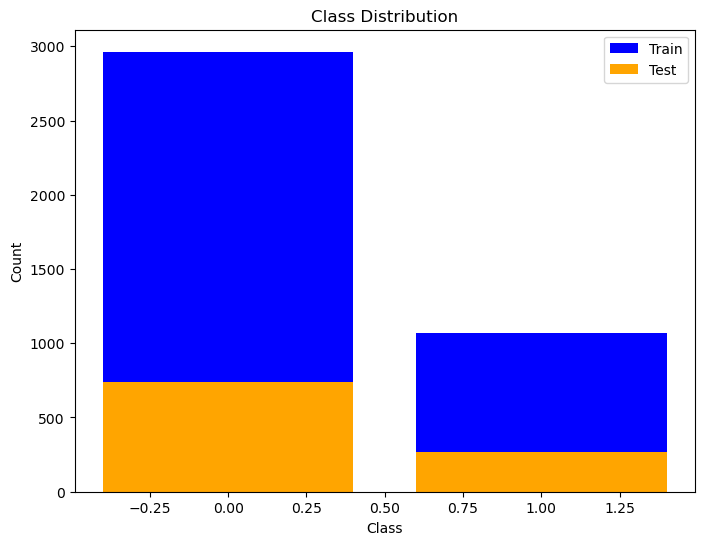

In [108]:
# Convert y_train and y_test to Pandas Series
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Count the number of samples in each class in the training set
train_class_counts = y_train_series.value_counts()

# Count the number of samples in each class in the testing set
test_class_counts = y_test_series.value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
plt.bar(train_class_counts.index, train_class_counts.values, color='blue', label='Train')
plt.bar(test_class_counts.index, test_class_counts.values, color='orange', label='Test')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.legend()
plt.show()

In [109]:
train_churn_count = pd.Series(y_train).value_counts()
test_churn_count = pd.Series(y_test).value_counts()

print("Churn count in y_train:")
print(train_churn_count)

print("\nChurn count in y_test:")
print(test_churn_count)

Churn count in y_train:
0    2964
1    1069
dtype: int64

Churn count in y_test:
0    742
1    267
dtype: int64


In [110]:
# Create an instance of SMOTETomek
smote_tomek = SMOTETomek()

# Apply SMOTETomek to the training data
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_encoded, y_train)

# Check the count of each class in the balanced training data
balanced_class_count = pd.Series(y_train_balanced).value_counts()
print("Class count in the balanced training data:")
print(balanced_class_count)

Class count in the balanced training data:
0    2881
1    2881
dtype: int64


In [111]:
# # Apply Borderline-SMOTE to the training data
# smote = BorderlineSMOTE()
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train)

# # Check the count of churn in the balanced training data
# balanced_churn_count = pd.Series(y_train_balanced).value_counts()
# print("Churn count in balanced training data:")
# print(balanced_churn_count)

In [112]:
# # Apply SMOTE to the training data
# smote = SMOTE()
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train)

# # Check the count of churn in the balanced training data
# balanced_churn_count = pd.Series(y_train_balanced).value_counts()
# print("Churn count in balanced training data:")
# print(balanced_churn_count)

## Train Models / Evaluate / Model Comparison

In [113]:
# Define the calculate_metrics function
def calculate_metrics(y_true, y_pred):
    metrics = {}
    metrics['f1_score'] = f1_score(y_true, y_pred)
    return metrics

In [114]:
# Initialize the models
models = [
    LogisticRegression(random_state=4, solver='liblinear', max_iter=1000),
    DecisionTreeClassifier(random_state=4, criterion='gini', min_samples_leaf=8, max_depth=5),
    RandomForestClassifier(random_state=4, n_estimators=100, max_depth=5),
    GradientBoostingClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    AdaBoostClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    SVC(random_state=4, kernel='rbf', C=1.0),
    KNeighborsClassifier(n_neighbors=5),
    GaussianNB(),
    XGBClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    LGBMClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    CatBoostClassifier(random_state=4, verbose=0, iterations=100)
]

model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting',
    'AdaBoost',
    'SVM',
    'KNN',
    'Naive Bayes',
    'XGBoost',
    'LightGBM',
    'CatBoost'
]

In [115]:
leaderboard_imbalanced = {}

for model, name in zip(models, model_names):
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)
    metrics = calculate_metrics(y_test, y_pred)
    leaderboard_imbalanced[name] = metrics
    
    # Print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['No', 'Yes']))
    print()

# Create a DataFrame from the leaderboard dictionary
leaderboard_df = pd.DataFrame(leaderboard_imbalanced).transpose()

# Format the F1-score column to display with two decimal places
leaderboard_df['Imbalanced Data F1-score'] = leaderboard_df['f1_score'].map('{:.2f}'.format)

# Print the leaderboard DataFrame
print("Leaderboard: Imbalance Data")
leaderboard_df.drop('f1_score', axis=1, inplace=True)
leaderboard_df

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          No       0.85      0.89      0.87       742
         Yes       0.65      0.56      0.60       267

    accuracy                           0.80      1009
   macro avg       0.75      0.73      0.74      1009
weighted avg       0.80      0.80      0.80      1009


Classification Report for Decision Tree:
              precision    recall  f1-score   support

          No       0.85      0.86      0.86       742
         Yes       0.60      0.58      0.59       267

    accuracy                           0.79      1009
   macro avg       0.73      0.72      0.72      1009
weighted avg       0.79      0.79      0.79      1009


Classification Report for Random Forest:
              precision    recall  f1-score   support

          No       0.82      0.92      0.87       742
         Yes       0.66      0.45      0.54       267

    accuracy                           0.79      10

,Imbalanced Data F1-score
Logistic Regression,0.60
Decision Tree,0.59
Random Forest,0.54
Gradient Boosting,0.60
AdaBoost,0.56
SVM,0.58
KNN,0.54
Naive Bayes,0.59
XGBoost,0.59
LightGBM,0.60


In [116]:
leaderboard_balanced = {}

for model, name in zip(models, model_names):
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_encoded)
    metrics = calculate_metrics(y_test, y_pred)
    leaderboard_balanced[name] = metrics
    
    # Print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['No', 'Yes']))
    print()

# Create a DataFrame from the leaderboard dictionary
leaderboard_df1 = pd.DataFrame(leaderboard_balanced).transpose()

 #Format the F1-score column to display with two decimal places
leaderboard_df1['Balanced Data F1-score'] = leaderboard_df1['f1_score'].map('{:.2f}'.format)

# Print the leaderboard DataFrame
print("Leaderboard: Balanced Data")
leaderboard_df1.drop('f1_score', axis=1, inplace=True)
leaderboard_df1

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          No       0.92      0.72      0.81       742
         Yes       0.51      0.82      0.63       267

    accuracy                           0.75      1009
   macro avg       0.72      0.77      0.72      1009
weighted avg       0.81      0.75      0.76      1009


Classification Report for Decision Tree:
              precision    recall  f1-score   support

          No       0.91      0.77      0.83       742
         Yes       0.55      0.78      0.64       267

    accuracy                           0.77      1009
   macro avg       0.73      0.77      0.74      1009
weighted avg       0.81      0.77      0.78      1009


Classification Report for Random Forest:
              precision    recall  f1-score   support

          No       0.91      0.74      0.82       742
         Yes       0.52      0.80      0.63       267

    accuracy                           0.75      10

,Balanced Data F1-score
Logistic Regression,0.63
Decision Tree,0.64
Random Forest,0.63
Gradient Boosting,0.64
AdaBoost,0.63
SVM,0.62
KNN,0.55
Naive Bayes,0.59
XGBoost,0.63
LightGBM,0.59


## Confusion matrix

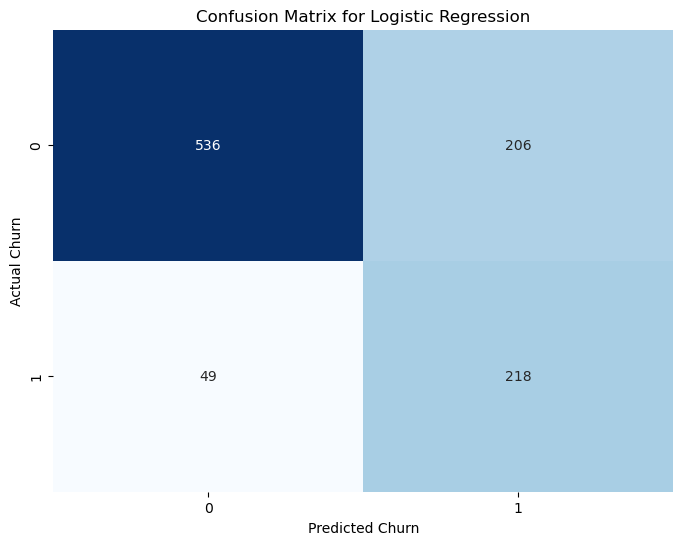

Confusion Matrix for Logistic Regression:
[[536 206]
 [ 49 218]]



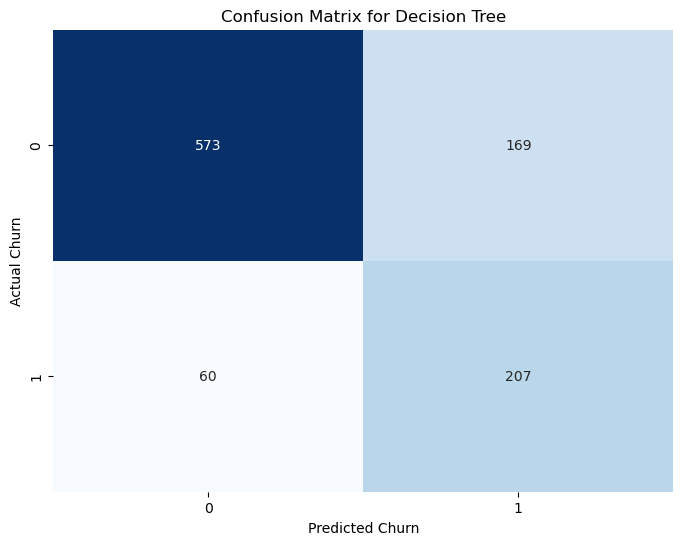

Confusion Matrix for Decision Tree:
[[573 169]
 [ 60 207]]



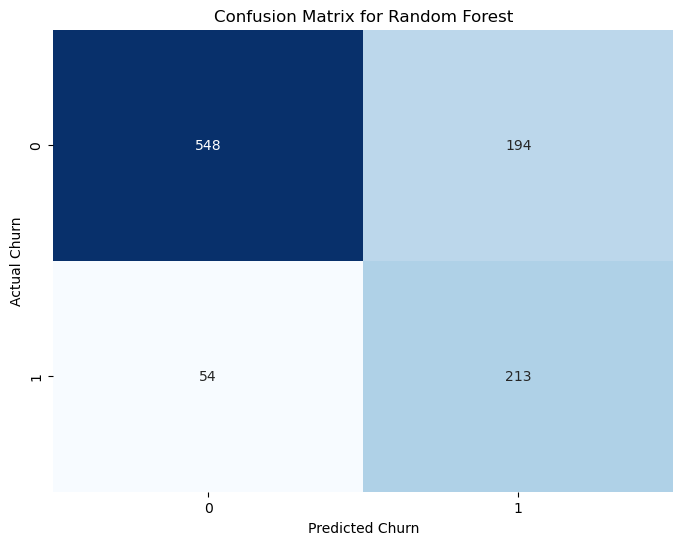

Confusion Matrix for Random Forest:
[[548 194]
 [ 54 213]]



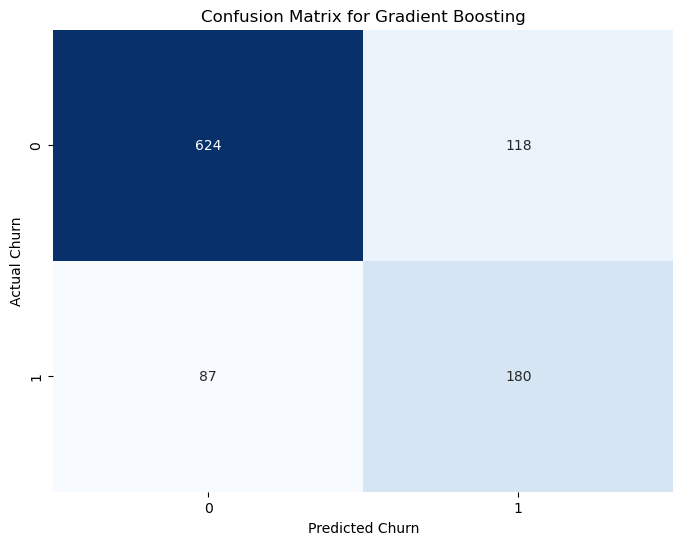

Confusion Matrix for Gradient Boosting:
[[624 118]
 [ 87 180]]



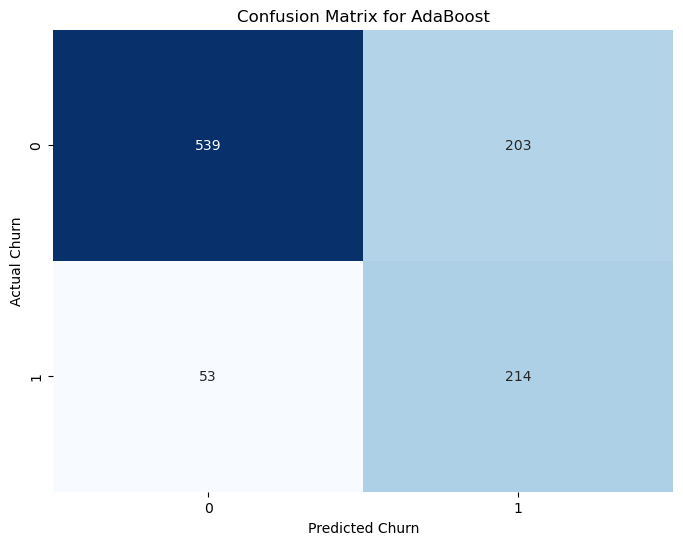

Confusion Matrix for AdaBoost:
[[539 203]
 [ 53 214]]



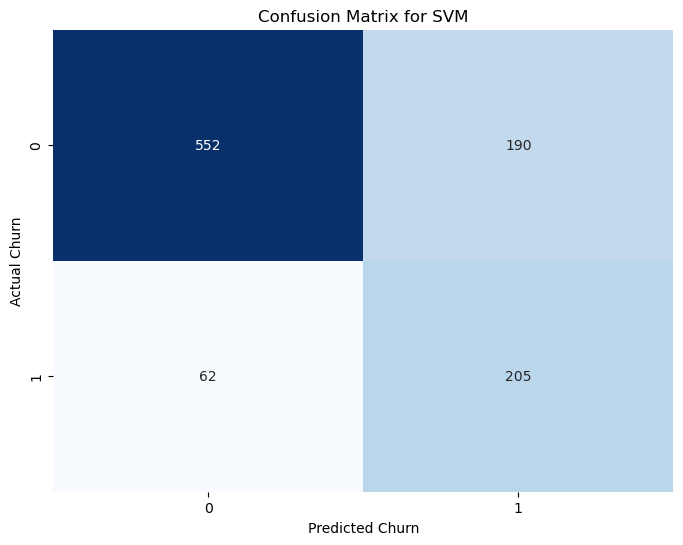

Confusion Matrix for SVM:
[[552 190]
 [ 62 205]]



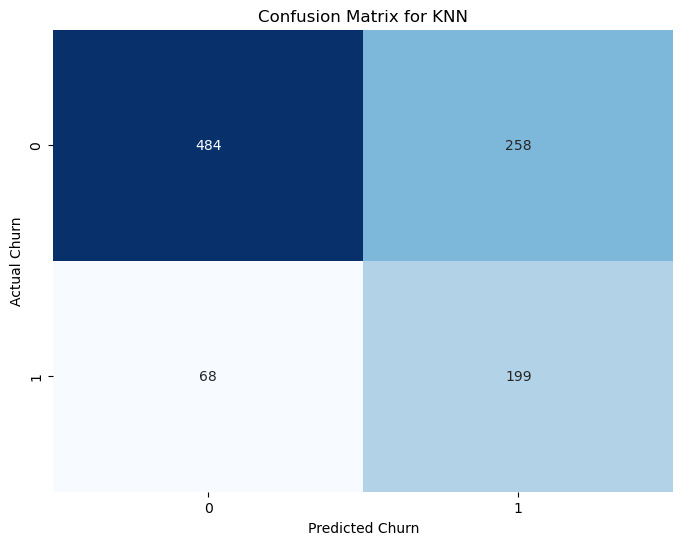

Confusion Matrix for KNN:
[[484 258]
 [ 68 199]]



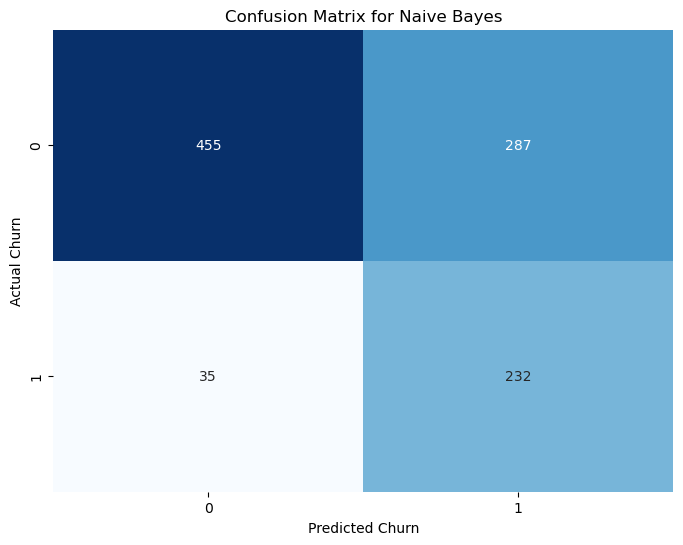

Confusion Matrix for Naive Bayes:
[[455 287]
 [ 35 232]]



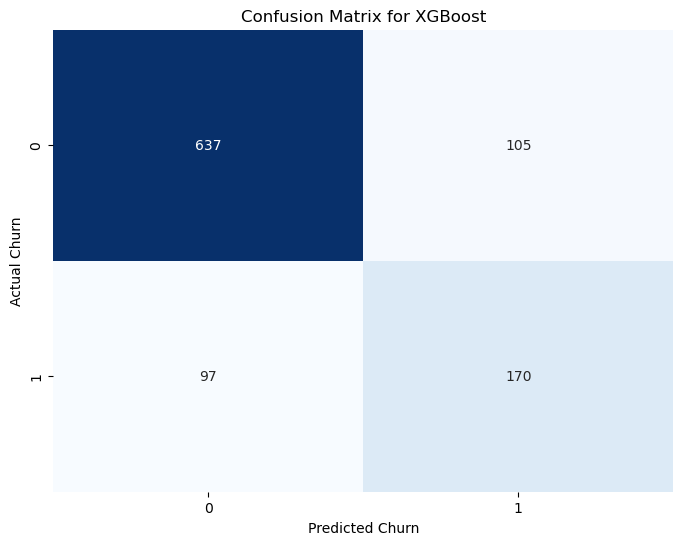

Confusion Matrix for XGBoost:
[[637 105]
 [ 97 170]]



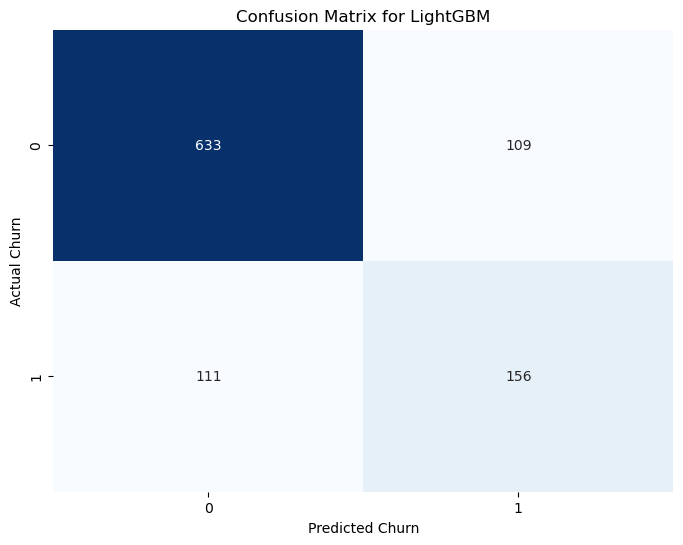

Confusion Matrix for LightGBM:
[[633 109]
 [111 156]]



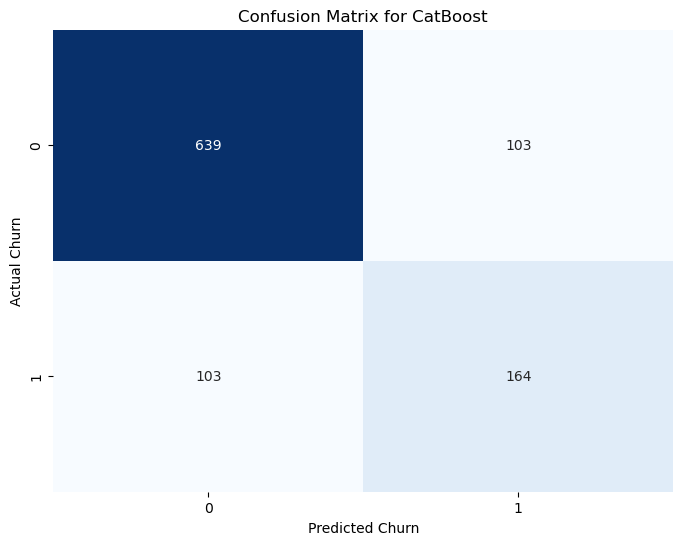

Confusion Matrix for CatBoost:
[[639 103]
 [103 164]]



In [117]:
# Iterate over each model and its corresponding name in the leaderboard
for model, name in zip(models, model_names):
    # Fit the model on the balanced training data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict the labels for the test data
    y_pred = model.predict(X_test_encoded)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Churn")
    plt.ylabel("Actual Churn")
    plt.show()
    
    # Print the confusion matrix
    print(f"Confusion Matrix for {name}:")
    print(cm)
    print()


## Hyperparameters tuning

In [118]:
# Define the models and their respective parameter grids
models = {
    'AdaBoost': AdaBoostClassifier(random_state=4),
    'Logistic Regression': LogisticRegression(random_state=4),
    'Random Forest' : RandomForestClassifier(random_state=4),
    'Gradient Boosting' : GradientBoostingClassifier(random_state=4)
}

leaderboard = {}

In [119]:
for name, model in models.items():
    # Get the available parameters for the model
    available_params = model.get_params()
    print(f"Available parameters for {name}: {available_params}\n")

# Perform hyperparameter tuning and store the best-tuned models
leaderboard = {}

Available parameters for AdaBoost: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': 4}

Available parameters for Logistic Regression: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 4, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Available parameters for Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 4, 'verbose': 0, 'warm_start': False}

Available parameters for Gradient Boosting: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': No

In [120]:
for name, model in models.items():
    # Define the selected parameter values for the model
    
    param_selections = {
    'AdaBoost': {'n_estimators': [100, 150, 200, 250, 300], 'learning_rate': [0.1, 0.05, 0.01, 0.001]},
    'Logistic Regression': {'C': [0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']},
    'Random Forest':  {'n_estimators': [50, 100, 150, 200, 300, 400, 500], 'max_depth': [5, 10, 20]},
    'Gradient Boosting': {'n_estimators': [100, 150, 200, 250, 300], 'learning_rate': [0.1, 0.05, 0.01, 0.001], 'max_depth': [3, 5, 7]}
     }
    
     #Set the verbosity level for printing progress
    verbose = 3 if name == 'Logistic Regression' else 0
    
    # Get the selected parameter values for the model
    param_grid = param_selections[name]
    
    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5, verbose=verbose, refit=True)
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters for {name}: {best_params}\n")
    
    
     # Predict using the best model
    y_pred = best_model.predict(X_test_encoded)
    f1 = f1_score(y_test, y_pred)
    f1_rounded = round(f1, 2)
    leaderboard[name] = {'Tuned F1-score': f1}

Best parameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 300}

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...........C=0.1, solver=liblinear;, score=0.801 total time=   0.0s
[CV 2/5] END ...........C=0.1, solver=liblinear;, score=0.798 total time=   0.0s
[CV 3/5] END ...........C=0.1, solver=liblinear;, score=0.817 total time=   0.0s
[CV 4/5] END ...........C=0.1, solver=liblinear;, score=0.795 total time=   0.0s
[CV 5/5] END ...........C=0.1, solver=liblinear;, score=0.813 total time=   0.0s
[CV 1/5] END ...............C=0.1, solver=lbfgs;, score=0.801 total time=   0.0s
[CV 2/5] END ...............C=0.1, solver=lbfgs;, score=0.796 total time=   0.0s
[CV 3/5] END ...............C=0.1, solver=lbfgs;, score=0.817 total time=   0.0s
[CV 4/5] END ...............C=0.1, solver=lbfgs;, score=0.795 total time=   0.0s
[CV 5/5] END ...............C=0.1, solver=lbfgs;, score=0.811 total time=   0.0s
[CV 1/5] END ...........C=0.1, solver=newton-cg;, sco

[CV 5/5] END ..........C=1000, solver=liblinear;, score=0.808 total time=   0.0s
[CV 1/5] END ..............C=1000, solver=lbfgs;, score=0.803 total time=   0.0s
[CV 2/5] END ..............C=1000, solver=lbfgs;, score=0.798 total time=   0.0s
[CV 3/5] END ..............C=1000, solver=lbfgs;, score=0.817 total time=   0.0s
[CV 4/5] END ..............C=1000, solver=lbfgs;, score=0.809 total time=   0.0s
[CV 5/5] END ..............C=1000, solver=lbfgs;, score=0.808 total time=   0.0s
[CV 1/5] END ..........C=1000, solver=newton-cg;, score=0.803 total time=   0.0s
[CV 2/5] END ..........C=1000, solver=newton-cg;, score=0.798 total time=   0.0s
[CV 3/5] END ..........C=1000, solver=newton-cg;, score=0.817 total time=   0.0s
[CV 4/5] END ..........C=1000, solver=newton-cg;, score=0.809 total time=   0.0s
[CV 5/5] END ..........C=1000, solver=newton-cg;, score=0.808 total time=   0.0s
[CV 1/5] END ................C=1000, solver=sag;, score=0.802 total time=   0.2s
[CV 2/5] END ...............

In [121]:
# Create a DataFrame for the tuned models
leaderboard_df2 = pd.DataFrame(leaderboard).transpose()
leaderboard_df2['Tuned F1-score'] = leaderboard_df2['Tuned F1-score'].round(2)

leaderboard_df2

,Tuned F1-score
AdaBoost,0.63
Logistic Regression,0.63
Random Forest,0.61
Gradient Boosting,0.64


In [122]:
# Filter leaderboard for selected models
selected_models = ['Gradient Boosting','Random Forest', 'Logistic Regression', 'AdaBoost']
filtered_df = leaderboard_df.loc[selected_models]

filtered_df1 = leaderboard_df1.loc[selected_models]

# Filter leaderboard_df2 for selected models
filtered_df2 = leaderboard_df2.loc[selected_models]

# Concatenate the filtered DataFrames
combined_df = pd.concat([filtered_df, filtered_df1, filtered_df2], axis=1)

# Print the combined DataFrame
combined_df

,Imbalanced Data F1-score,Balanced Data F1-score,Tuned F1-score
Gradient Boosting,0.60,0.64,0.64
Random Forest,0.54,0.63,0.61
Logistic Regression,0.60,0.63,0.63
AdaBoost,0.56,0.63,0.63


## Export key components

In [ ]:
# # Create a dictionary to store the exported variables
# exported_data = {
#     'categorical_imputer': categorical_imputer,
#     'numerical_imputer': numerical_imputer,
#     'encoder': encoder,
#     'scaler': scaler,
#     'best_model': best_model
# }

In [ ]:
# # Create a folder to store the exported data
# folder_name = 'exported_data_folder'
# os.makedirs(folder_name, exist_ok=True)

In [ ]:
# # Export the variables
# exported_data_path = os.path.join(folder_name, 'exported_data.pkl')
# with open(exported_data_path, 'wb') as file:
#     pickle.dump(exported_data, file)

In [ ]:
# # Generate the requirements.txt file
#pip freeze > exported_data_folder/requirements.txt

In [ ]:
# # Zip the exported_data folder
# shutil.make_archive('exported_data', 'zip', 'exported_data')

# print("Exported data has been zipped.")